# Importing necessary packages

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.1 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism

import torch

print_config()

MONAI version: 1.3.dev2336
Numpy version: 1.23.5
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 697f3ecbe9c7743e47778c13e4604ed225a3b1fd
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.10.1
Pillow version: 9.4.0
Tensorboard version: 2.12.3
gdown version: 4.6.6
TorchVision version: 0.15.2+cu118
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optiona






1.  Activations and Activationsd are transforms that apply a given activation function to the input image. The activation function can be specified as a string, such as "relu" or "sigmoid".
2.  AsDiscrete and AsDiscreted are transforms that convert the input image to a discrete representation, such as a label image. The number of labels can be specified as an integer.
3. Compose is a transform that composes multiple other transforms together. This can be used to create a complex transform chain that can be applied to an image.
4. Invertd is a transform that inverts the effects of another transform. This can be used to undo a previous transformation, such as a spatial crop or a random flip.
5. LoadImaged is a transform that loads an image from a file. The file 6.format can be specified as a string.
MapTransform is a transform that applies a function to each element of an image. The function can be any Python function that takes an image and returns an image.
6. NormalizeIntensityd is a transform that normalizes the intensity of an image. This can be useful for improving the performance of machine learning models.
7. Orientationd is a transform that reorients an image to a given coordinate system. The coordinate system can be specified as a string, such as "RAS" or "LPS".
8. RandFlipd is a transform that flips an image randomly along a given axis. The axis can be specified as an integer.
RandScaleIntensityd is a transform that randomly scales the intensity of an image. The scale factor can be specified as a float.
9. RandShiftIntensityd is a transform that randomly shifts the intensity of an image. The shift amount can be specified as a float.
10. RandSpatialCropd is a transform that randomly crops an image. The crop size can be specified as a tuple of integers.
11. Spacingd is a transform that changes the spacing of an image. The new spacing can be specified as a tuple of floats.
12. EnsureTyped and EnsureChannelFirstd are transforms that ensure that the input image is of a certain type and has the channels in the first dimension. This can be useful for some machine learning models.


Set deterministic training for reproducibility

In [ ]:
set_determinism(seed=0)

In [ ]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d


The ConvertToMultiChannelBasedOnBratsClassesd class is a transform that converts a label image to a multi-channel image based on the BRATS tumor classes. The BRATS tumor classes are:

1: Peritumoral edema
2: GD-enhancing tumor
3: Necrotic and non-enhancing tumor core
The possible classes after converting to multi-channel are:

TC (Tumor core): This is the merged label 2 and 3.
WT (Whole tumor): This is the merged labels 1, 2, and 3.
ET (Enhancing tumor): This is the label 2.
The ConvertToMultiChannelBasedOnBratsClassesd class inherits from the MapTransform class, which means that it takes a dictionary as input and returns a dictionary as output. The keys of the dictionary are the names of the input and output images. The values of the dictionary are the images themselves.

The __call__ method of the ConvertToMultiChannelBasedOnBratsClassesd class takes a dictionary as input and returns a dictionary as output. The input dictionary must contain a key named label. The output dictionary will also have a key named label. The value of the output label key will be a multi-channel image with three channels. The first channel will contain the TC class, the second channel will contain the WT class, and the third channel will contain the ET class.

In [ ]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


These transforms are used to preprocess and normalize medical images for training and validation, respectively.

The train_transform consists of the following steps:

Load the image and label data from Nifti files.
Ensure that the image is in channel first format.
Ensure that the image and label data are of the correct type.
Convert the label data to a multi-channel representation.
Reorient the image and label data to the RAS coordinate system.
Normalize the spacing of the image and label data.
Randomly crop the image and label data to a size of 224x224x144.
Randomly flip the image and label data along the spatial axes.
Normalize the intensity of the image data.
Randomly scale the intensity of the image data.
Randomly shift the intensity of the image data.
The val_transform is similar to the train_transform, but it does not include the random cropping, flipping, scaling, and shifting steps. This is because the validation data should not be augmented, as this could introduce bias into the evaluation of the model.

Setting up directory

In [ ]:

root_dir = "/content/data"
print(root_dir)

/content/data


# Load the dataset

In [ ]:
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    #transform=train_transform,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    #transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

Task01_BrainTumour.tar: 7.09GB [07:02, 18.0MB/s]                            

2023-09-01 15:28:09,647 - INFO - Downloaded: /content/data/Task01_BrainTumour.tar


2023-09-01 15:28:46,530 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2023-09-01 15:28:46,531 - INFO - Writing into directory: /content/data.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


The train_ds dataset is created using the DecathlonDataset class from the MONAI medical imaging library. The DecathlonDataset class is a generic dataset class that can be used to load data from the MICCAI BraTS 2020 challenge.

The train_ds dataset is configured with the following parameters:

root_dir: The directory where the data is stored.
task: The task that the dataset is for. In this case, the task is Task01_BrainTumour.
transform: The transform that is used to preprocess the data. In this case, the train_transform transform is used.
section: The section of the dataset that is used. In this case, the training section is used.
download: Whether to download the data if it is not already stored in the root_dir directory.
cache_rate: The rate at which the data is cached in memory. A value of 0.0 means that no data is cached.
num_workers: The number of worker threads that are used to load the data.
The val_ds dataset is configured similarly to the train_ds dataset, but it uses the val_transform transform instead of the train_transform transform.

The DataLoader class is used to create a data loader for each dataset. The data loader is used to iterate over the data in batches. The batch size is set to 1 in this case.

The shuffle parameter is set to True for the train_loader and False for the val_loader. This means that the data in the train_loader is shuffled after each epoch, but the data in the val_loader is not shuffled.

The num_workers parameter is set to 4 for both data loaders. This means that 4 worker threads are used to load the data in parallel.

# Visualize the Data

image shape: torch.Size([4, 240, 240, 155])


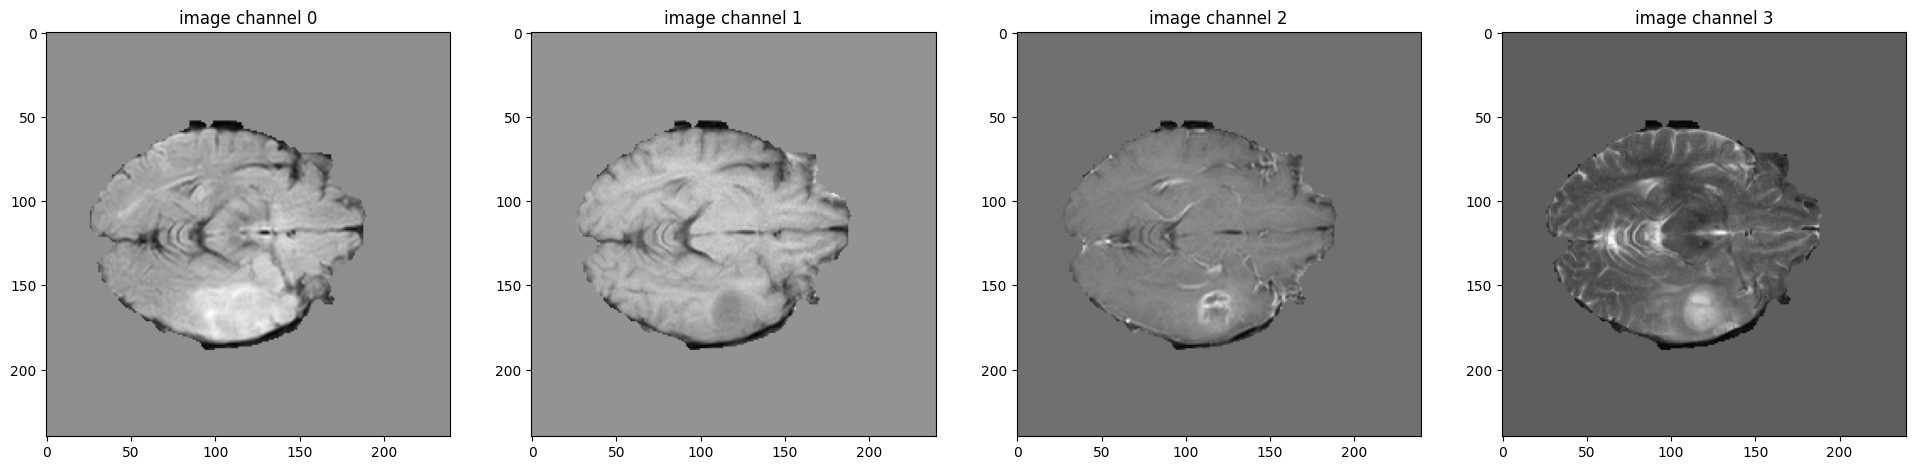

label shape: torch.Size([3, 240, 240, 155])


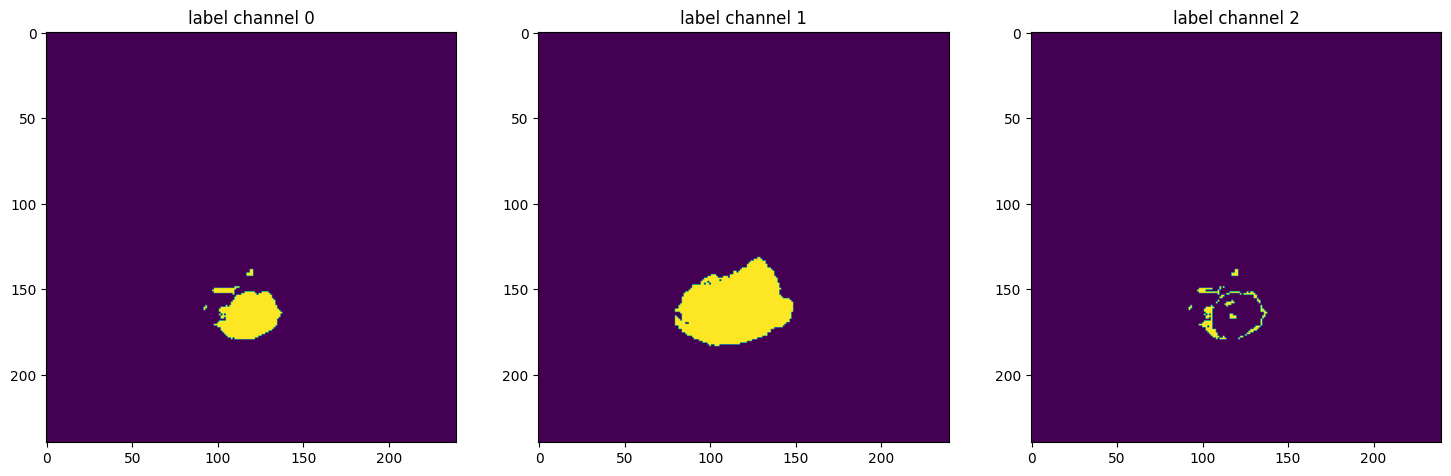

In [ ]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = val_ds[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()

# Train the model

In [ ]:
max_epochs = 10 # could not train more than 10 epochs because of free colab gpu limitations
val_interval = 2 #increase for faster training
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 5e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

The max_epochs variable defines the maximum number of epochs to train the model.
The val_interval variable defines the number of epochs between validations.
The VAL_AMP variable defines whether to use automatic mixed precision (AMP) during validation.
The device variable defines the device to use for training and inference.
The model variable defines the model to be trained.
The loss_function variable defines the loss function to be used.
The optimizer variable defines the optimizer to be used.
The lr_scheduler variable defines the learning rate scheduler to be used.
The dice_metric variable defines the dice metric to be used for evaluation.
The dice_metric_batch variable defines the dice metric to be used for batch evaluation.
The post_trans variable defines the post-processing transform to be used.
The inference function defines the inference method.
The scaler variable defines the AMP scaler to be used.
The torch.backends.cudnn.benchmark variable defines whether to enable cuDNN benchmark.
The max_epochs and val_interval variables control the training and validation process. The device variable controls the hardware to be used for training and inference. The model, loss_function, optimizer, and lr_scheduler variables control the training process. The dice_metric, dice_metric_batch, and post_trans variables control the evaluation process. The inference function defines the inference method. The scaler variable controls the AMP scaler to be used. The torch.backends.cudnn.benchmark variable controls whether to enable cuDNN benchmark.

The VAL_AMP variable controls whether to use AMP during validation. AMP is a technique that uses both floating-point and integer arithmetic to speed up training. It is especially useful for deep learning models that use a lot of floating-point operations.

The torch.backends.cudnn.benchmark variable controls whether to enable cuDNN benchmark. cuDNN is a library that provides highly optimized implementations of deep learning operations for NVIDIA GPUs. Enabling cuDNN benchmark can improve the performance of deep learning models on NVIDIA GPUs.

In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/10
1/388, train_loss: 0.9782, step time: 10.3115
2/388, train_loss: 0.9800, step time: 1.0623
3/388, train_loss: 0.9865, step time: 1.0724
4/388, train_loss: 0.9464, step time: 1.0627
5/388, train_loss: 0.9807, step time: 1.1126
6/388, train_loss: 0.9277, step time: 1.1402
7/388, train_loss: 0.9666, step time: 1.0902
8/388, train_loss: 0.9332, step time: 1.2339
9/388, train_loss: 0.9824, step time: 1.1765
10/388, train_loss: 0.9350, step time: 1.0739
11/388, train_loss: 0.8897, step time: 1.0418
12/388, train_loss: 0.8812, step time: 1.0939
13/388, train_loss: 0.9593, step time: 1.1191
14/388, train_loss: 0.8909, step time: 1.1411
15/388, train_loss: 0.9245, step time: 1.1679
16/388, train_loss: 0.9467, step time: 1.2491
17/388, train_loss: 0.9701, step time: 1.2196
18/388, train_loss: 0.9314, step time: 1.1217
19/388, train_loss: 0.9553, step time: 1.0904
20/388, train_loss: 0.8783, step time: 1.1304
21/388, train_loss: 0.9350, step time: 1.1576
22/388, train_loss: 

# Plot the loss and metric

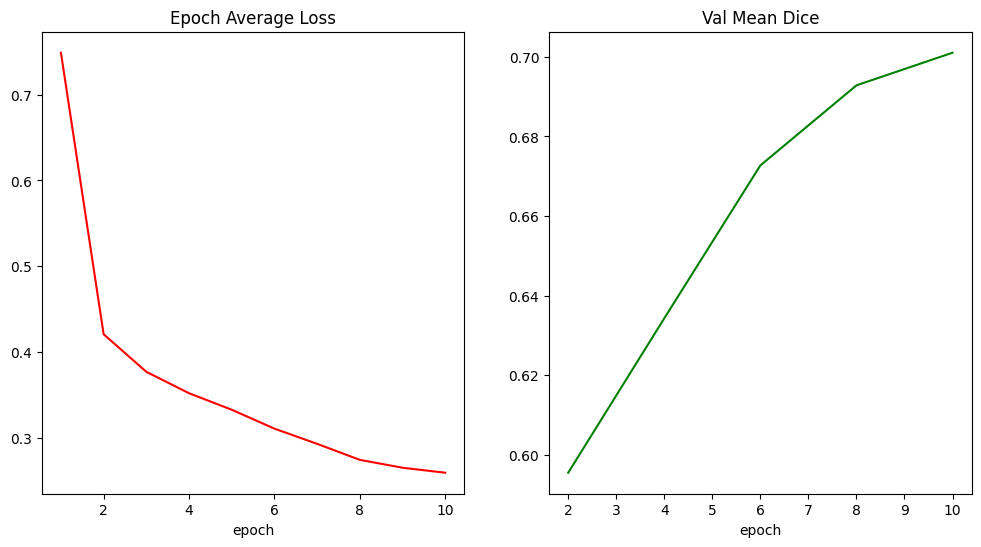

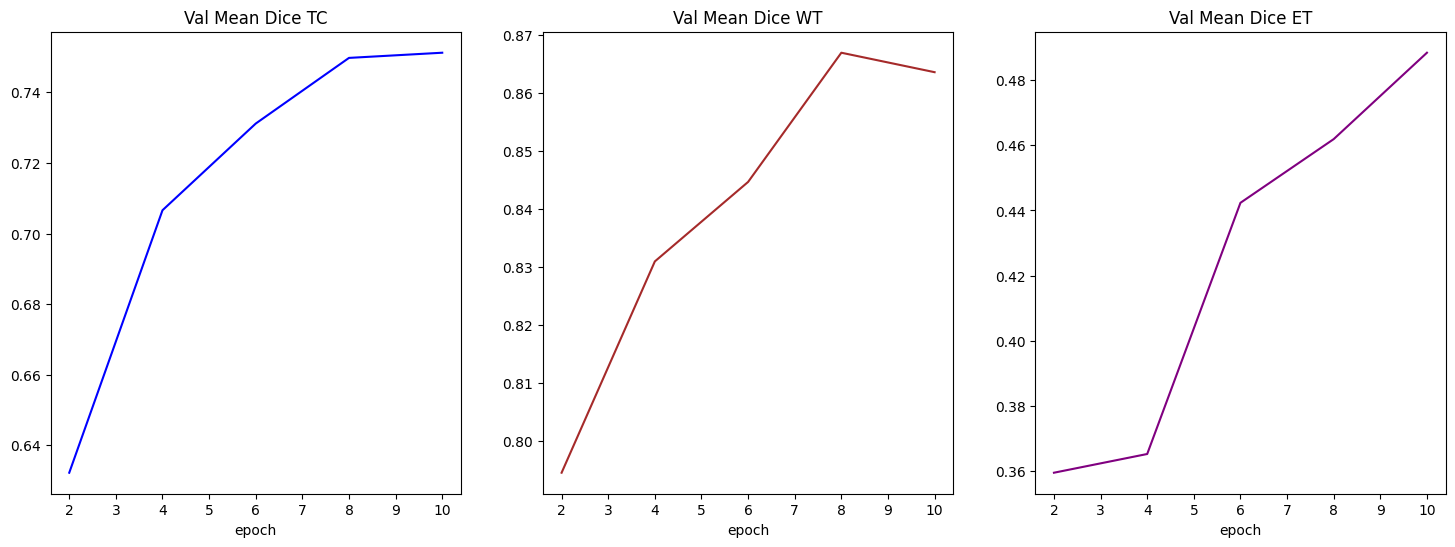

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

# Check best model output with the input image and label

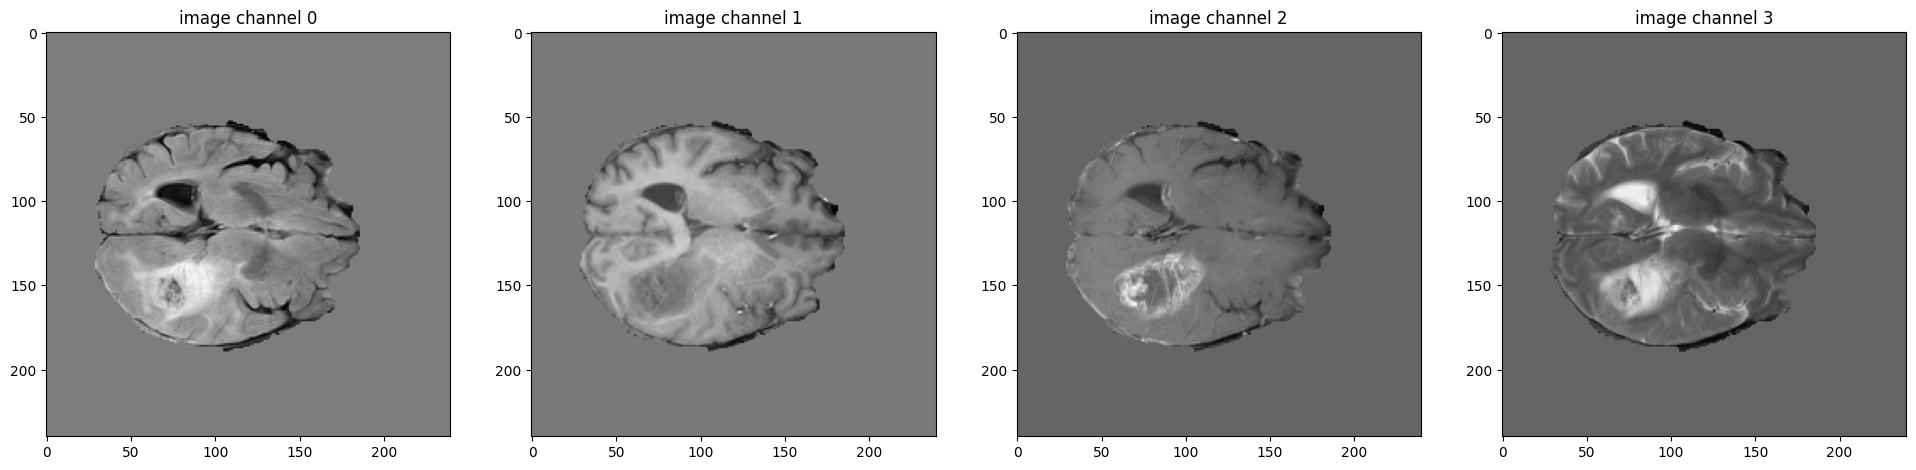

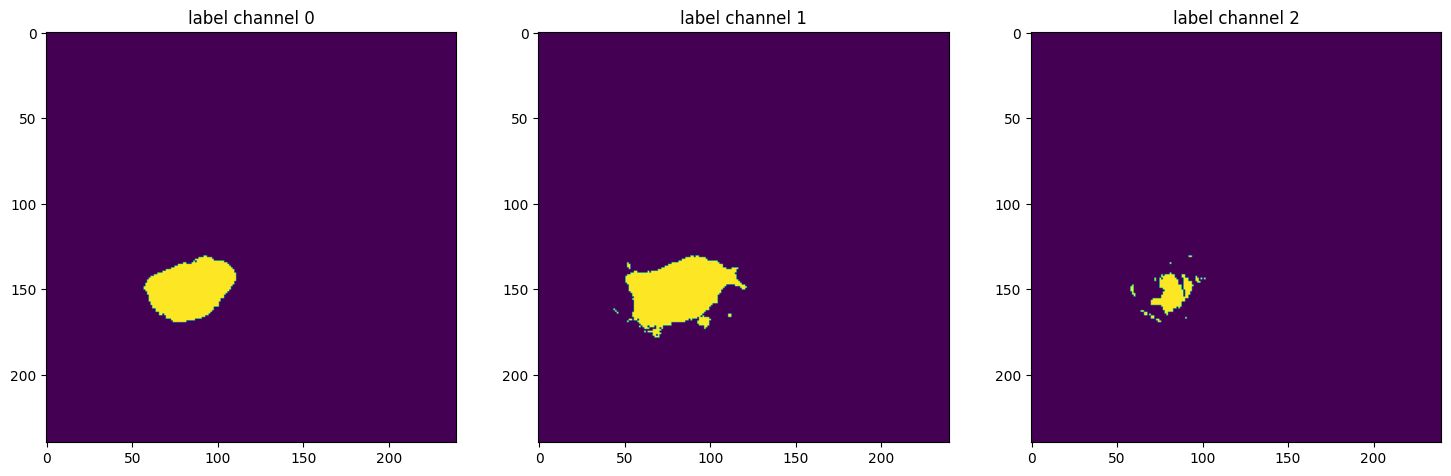

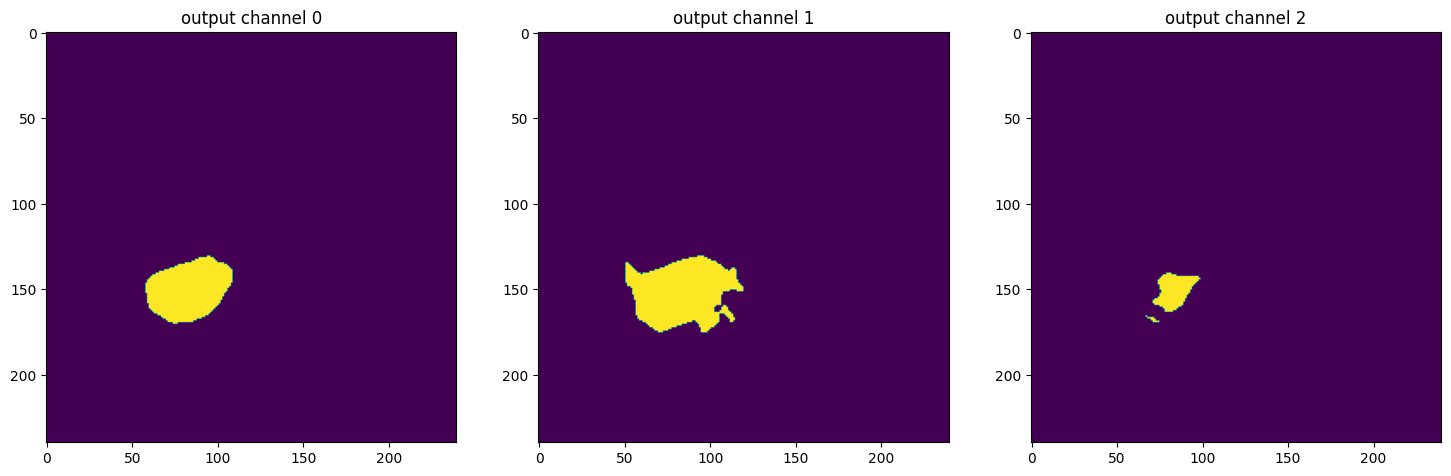

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[6]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()


the code first loads the best model weights from the file best_metric_model.pth into the model. Then, it sets the model to evaluation mode, which means that the model will not update its weights during inference. Next, it selects one image from the validation dataset and performs inference on the image. The image is first transferred to the GPU (if available) using the to(device) function. The image is then passed to the inference function, which performs sliding window inference on the image. The output of the inference function is then passed to the post_trans function, which applies post-processing to the output.

# Save the model and download it locally

In [ ]:
torch.save(model.state_dict(), "best_metric_model.pth")


In [ ]:
from google.colab import files
files.download("best_metric_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluate the model

In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

val_org_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_org_transforms,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=0,
)
val_org_loader = DataLoader(val_org_ds, batch_size=1, shuffle=False, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        Activationsd(keys="pred", sigmoid=True),
        AsDiscreted(keys="pred", threshold=0.5),
    ]
)

This code loads a pre-trained segmentation model and evaluates its performance on a validation dataset. The model is evaluated using the Dice coefficient, which is a measure of the overlap between the predicted masks and the ground truth masks. The code also prints the Dice coefficient for each tissue class (TC, WT, and ET).

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        val_data["pred"] = inference(val_inputs)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

    metric_org = dice_metric.aggregate().item()
    metric_batch_org = dice_metric_batch.aggregate()

    dice_metric.reset()
    dice_metric_batch.reset()

metric_tc, metric_wt, metric_et = metric_batch_org[0].item(), metric_batch_org[1].item(), metric_batch_org[2].item()

print("Metric on original image spacing: ", metric_org)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")

Metric on original image spacing:  0.701056182384491
metric_tc: 0.7512
metric_wt: 0.8636
metric_et: 0.4884


# Trying a pretrained model from the MONAI model zoo

In this next section we'll be loading a pretrained model from the monai model zoo. We will test the model with images from the validation dataset and visualize the results. No transfer learning or fine tuning will be applied due to computational restraints.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## setting up imports

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2023-09-06 15:57:22.696331: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.data import decollate_batch
from monai.bundle import ConfigParser, download

from monai.config import print_config

from monai.utils import set_determinism

import torch

print_config()

MONAI version: 1.3.dev2336
Numpy version: 1.23.5
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 697f3ecbe9c7743e47778c13e4604ed225a3b1fd
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.10.1
Pillow version: 9.4.0
Tensorboard version: 2.12.3
gdown version: 4.6.6
TorchVision version: 0.15.2+cu118
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit

In [ ]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

In [ ]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

In [ ]:
root_dir='/content/data'
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=2,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=2,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

2023-09-05 13:01:01,248 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2023-09-05 13:01:01,249 - INFO - File exists: /content/data/Task01_BrainTumour.tar, skipped downloading.
2023-09-05 13:01:01,254 - INFO - Non-empty folder exists in /content/data/Task01_BrainTumour, skipped extracting.


## Loading the model from MONAI model zoo

This code downloads a pre-trained segmentation model for brain tumor segmentation from the Model Zoo. The model is named brats_mri_segmentation and the version is 0.4.8. The model is downloaded to the directory ./models.
You can download any model you desire by chnging the model name and version following this link: https://monai.io/model-zoo.html

In [ ]:
model_name = "brats_mri_segmentation"
model_version = "0.4.8"
zoo_dir = os.path.abspath("./models")

download(name=model_name, version=model_version, bundle_dir=zoo_dir)

name brats_mri_segmentation
version 0.4.8
bundle_dir /content/models
source github
repo None
url None
remove_prefix monai_
progress True
2023-09-05 12:00:33,092 - INFO - --- input summary of monai.bundle.scripts.download ---
2023-09-05 12:00:33,103 - INFO - > name: 'brats_mri_segmentation'
2023-09-05 12:00:33,103 - INFO - > version: '0.4.8'
2023-09-05 12:00:33,104 - INFO - > bundle_dir: '/content/models'
2023-09-05 12:00:33,105 - INFO - > source: 'github'
2023-09-05 12:00:33,108 - INFO - > remove_prefix: 'monai_'
2023-09-05 12:00:33,109 - INFO - > progress: True
2023-09-05 12:00:33,110 - INFO - ---




brats_mri_segmentation_v0.4.8.zip: 33.5MB [00:00, 38.4MB/s]                            

2023-09-05 12:00:34,032 - INFO - Downloaded: /content/models/brats_mri_segmentation_v0.4.8.zip
2023-09-05 12:00:34,034 - INFO - Expected md5 is None, skip md5 check for file /content/models/brats_mri_segmentation_v0.4.8.zip.
2023-09-05 12:00:34,037 - INFO - Writing into directory: /content/models.


the next code defines the local system and filesystem settings by setting the output directory to ./monai_results and the device to use to cuda:0 if available, otherwise cpu. It then parses the variables in the config file inference.json using the ConfigParser module. The config file contains the information about the model, the data, and the preprocessing, inference, and postprocessing steps. The code then updates the config variables to match the local filesystem by setting the bundle_root variable to zoo_dir and the output_dir variable to output_dir. Finally, it asks the config file to generate the functions needed to process new data by calling the get_parsed_content() method on the preprocessing, network, inferer, and postprocessing keys.

In [ ]:
# The model's config file dynamically generates the functions needed to process new data.

# Define our local system and filesystem.
output_dir = os.path.abspath("./monai_results")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Parse the variables in the config file.
model_config_file = os.path.join(zoo_dir, model_name, "configs", "inference.json")
model_config = ConfigParser()
model_config.read_config(model_config_file)

# Update the confir variables to match our filesystem.
model_config["bundle_root"] = zoo_dir
model_config["output_dir"] = output_dir

# Identify which version of the model we want to load (each version is a
#    "checkpoint").  For most models, the "best" checkpoint is called "model.pt"
#    and it is stored in the models subdir.
checkpoint = os.path.join(zoo_dir, model_name, "models", "model.pt")

# Ask the config file to generate the functions needed to process new data.
#    These functions are adapted to our system by the config variables we
#    modified above.  The order of first defining variables and then creating the
#    functions is critical.
preprocessing = model_config.get_parsed_content("preprocessing")

model = model_config.get_parsed_content("network").to(device)

inferer = model_config.get_parsed_content("inferer")

postprocessing = model_config.get_parsed_content("postprocessing")

In [ ]:
model.load_state_dict(torch.load(checkpoint, map_location=device))
model.eval()
results = []
with torch.no_grad():
    for d in val_loader:
        images = d["image"].to(device)
        d["pred"] = inferer(images, network=model)
        results.append([postprocessing(i) for i in decollate_batch(d)])


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/monai/transforms/compose.py:355: UserWarning: inverse has been called but no invertible transforms have been supplied
  warnings.warn("inverse has been called but no invertible transforms have been supplied")


2023-09-05 13:16:12,593 INFO image_writer.py:197 - writing: /content/monai_results/BRATS_277/BRATS_277_seg.nii.gz
2023-09-05 13:16:13,797 INFO image_writer.py:197 - writing: /content/monai_results/BRATS_471/BRATS_471_seg.nii.gz
2023-09-05 13:16:15,067 INFO image_writer.py:197 - writing: /content/monai_results/BRATS_035/BRATS_035_seg.nii.gz
2023-09-05 13:16:16,623 INFO image_writer.py:197 - writing: /content/monai_results/BRATS_043/BRATS_043_seg.nii.gz
2023-09-05 13:16:18,277 INFO image_writer.py:197 - writing: /content/monai_results/BRATS_236/BRATS_236_seg.nii.gz
2023-09-05 13:16:20,117 INFO image_writer.py:197 - writing: /content/monai_results/BRATS_044/BRATS_044_seg.nii.gz
2023-09-05 13:16:21,945 INFO image_writer.py:197 - writing: /content/monai_results/BRATS_225/BRATS_225_seg.nii.gz
2023-09-05 13:16:24,150 INFO image_writer.py:197 - writing: /content/monai_results/BRATS_293/BRATS_293_seg.nii.gz
2023-09-05 13:16:26,032 INFO image_writer.py:197 - writing: /content/monai_results/BRATS

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-424334d4826d>", line 5, in <cell line: 4>
    for d in val_loader:
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 633, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1328, in _next_data
    idx, data = self._get_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1294, in _get_data
    success, data = self._try_get_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1132, in _try_get_data
    data = self._data_queue.get(timeout=timeout)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/pyt

Custom TB Handler failed, unregistering


The code loads the state dictionary of the model from the checkpoint file checkpoint. The state dictionary contains the parameters of the model that were trained on the training dataset. The code then sets the model to evaluation mode, which means that the gradients will not be calculated. The code then iterates over the validation dataset. For each image in the validation dataset, the code:

Loads the image into the GPU memory.
Runs the image through the inference function, which generates the predicted segmentation masks.
Appends the predicted segmentation masks to the results list.
The results list will contain the predicted segmentation masks for all of the images in the validation dataset. These masks can then be used to evaluate the performance of the model. The error showing there is due to GPU memory constraints and not being able to run inference on the totality of the validation data.

## Visualising results

the next code snippet is to visualize ground truth masks from the training set along side predicted mask with the monnai model

In [ ]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Paths to the data and results folders
data_folder = '/content/data/Task01_BrainTumour/'  # Update with your actual data folder path
results_folder = '/content/monai_results/BRATS_436'  # Update with your monai_results folder path

# Example file names
example_name = 'BRATS_436'

# Load the ground truth mask
mask_file = os.path.join(data_folder, 'labelsTr', f'{example_name}.nii.gz')
mask_data = nib.load(mask_file).get_fdata()

# Load the predicted mask
predicted_mask_file = os.path.join(results_folder, f'{example_name}_seg.nii.gz')
predicted_mask_data = nib.load(predicted_mask_file).get_fdata()

# Determine the dimension with the maximum number of slices
max_dimension = np.argmax(mask_data.shape)

# Define the range of slices to display (75 to 89)
start_slice = 75
end_slice = 89

# Calculate the number of rows and columns for subplots
num_slices_to_display = end_slice - start_slice + 1
num_rows = int(np.ceil(np.sqrt(num_slices_to_display)))
num_cols = int(np.ceil(num_slices_to_display / num_rows))

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, 2 * num_cols, figsize=(12, 12))

# Define colormap and color range
cmap = plt.cm.get_cmap('viridis')
vmin = 0  # Minimum value for colormap
vmax = 1  # Maximum value for colormap

# Loop through and display the specified range of slices for both masks
for slice_idx in range(start_slice, end_slice + 1):
    if max_dimension == 0:
        slice_mask = mask_data[slice_idx, :, :]
        slice_predicted_mask = predicted_mask_data[slice_idx, :, :]
    elif max_dimension == 1:
        slice_mask = mask_data[:, slice_idx, :]
        slice_predicted_mask = predicted_mask_data[:, slice_idx, :]
    else:
        slice_mask = mask_data[:, :, slice_idx]
        slice_predicted_mask = predicted_mask_data[:, :, slice_idx]

    display_idx = slice_idx - start_slice  # Index for subplots
    row_idx = display_idx // num_cols
    col_idx = display_idx % num_cols

    # Display the ground truth mask
    axs[row_idx, col_idx * 2].imshow(slice_mask, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[row_idx, col_idx * 2].set_title(f'GT Slice {slice_idx}')
    axs[row_idx, col_idx * 2].axis('off')

    # Display the predicted mask
    axs[row_idx, col_idx * 2 + 1].imshow(slice_predicted_mask, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[row_idx, col_idx * 2 + 1].set_title(f'Predicted Slice {slice_idx}')
    axs[row_idx, col_idx * 2 + 1].axis('off')

# Create a colorbar for both masks
cbar = fig.colorbar(axs[0, 0].imshow(np.zeros_like(slice_mask), cmap=cmap, vmin=vmin, vmax=vmax),
                    ax=axs.ravel().tolist(), orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Mask Intensity')

# Ensure proper layout
plt.tight_layout()

# Show the figure
plt.show()

Copy the results of segmentation to google drive to save the results and exloit them later.

In [ ]:
import shutil

source_folder = '/content/monai_results'
destination_folder = '/content/drive/MyDrive/monai_results'

shutil.copytree(source_folder, destination_folder)


'/content/drive/MyDrive/monai_results'

### Visualising using Nibabel

In [ ]:
!pip install nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 26.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import nibabel as nib
# Image settings
from nilearn import plotting
import pylab as plt
%matplotlib inline


In [ ]:
img=nib.load('/content/monai_results/BRATS_035/BRATS_035_seg.nii.gz')

Viewing one slice

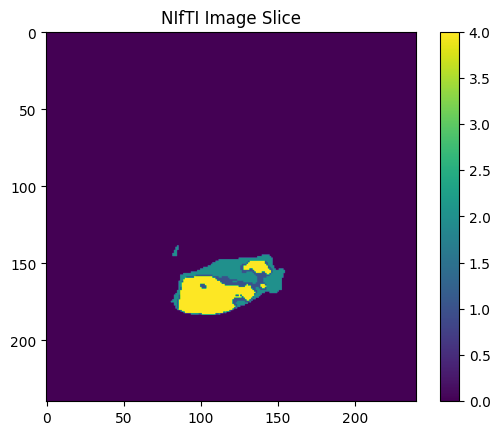

In [ ]:
img_data = img.get_fdata()

# Choose a slice to visualize (e.g., the middle slice along the Z-axis)
slice_to_visualize = img_data[:, :, img_data.shape[2] // 2]

# Display the slice using matplotlib
plt.imshow(slice_to_visualize, cmap='gray')
plt.title('NIfTI Image Slice')
plt.colorbar()
plt.show()

Viewing all slices

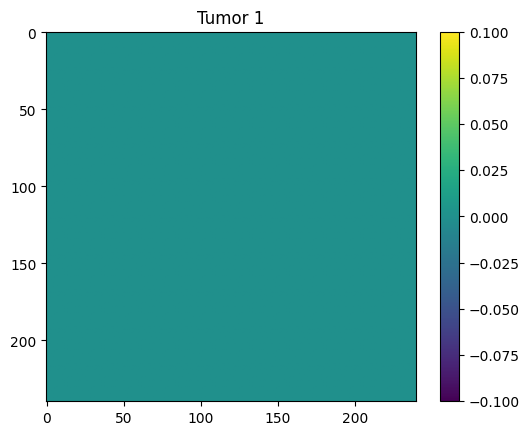

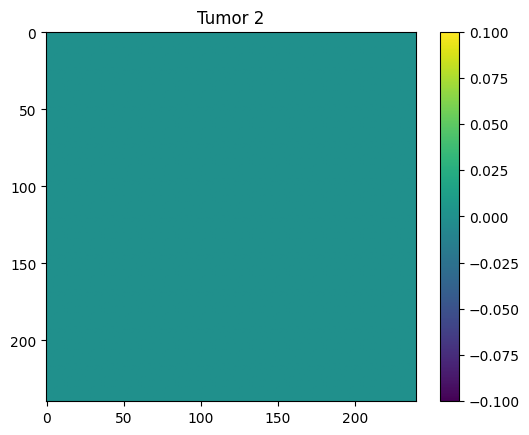

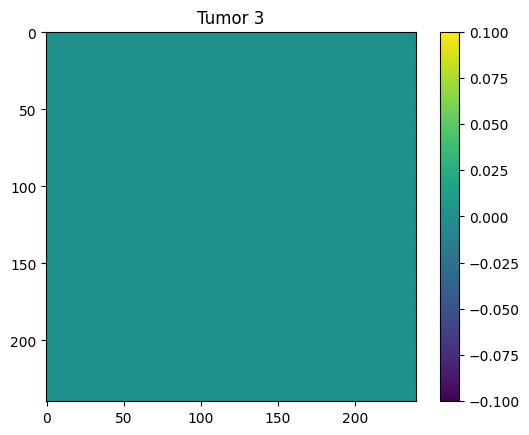

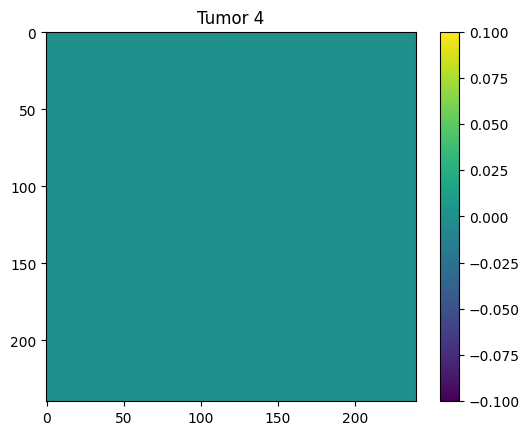

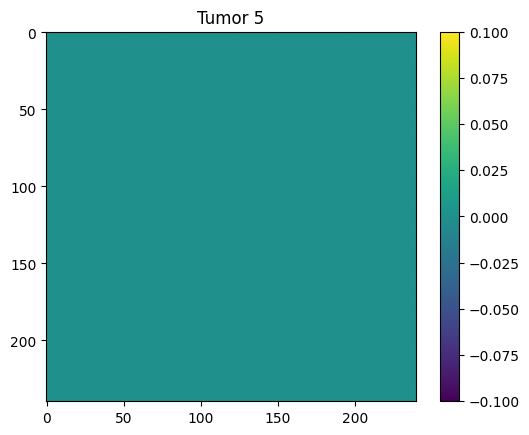

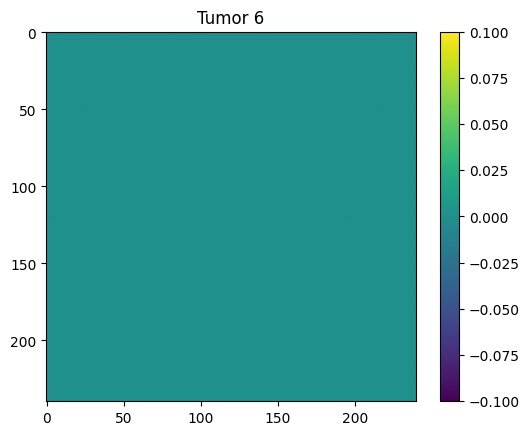

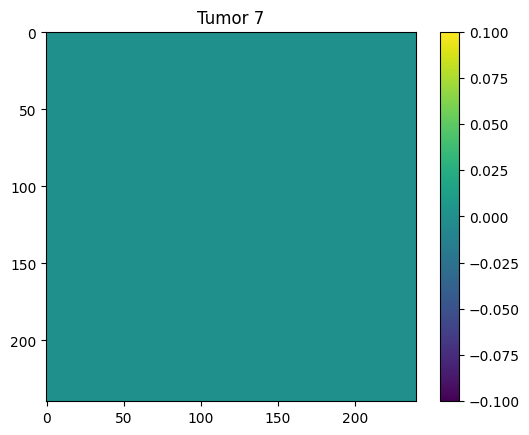

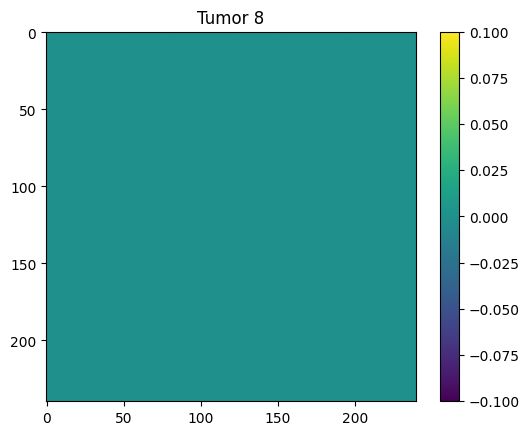

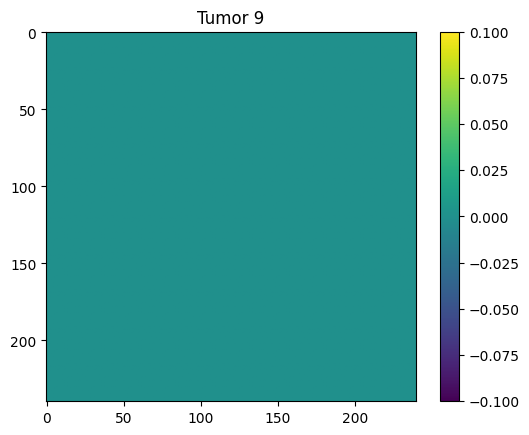

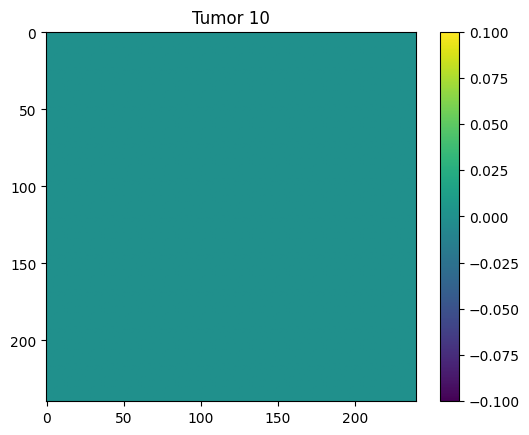

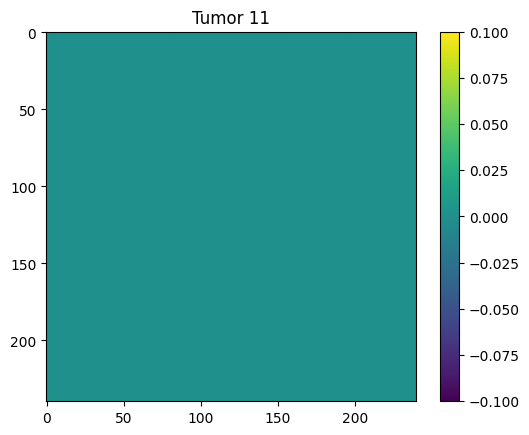

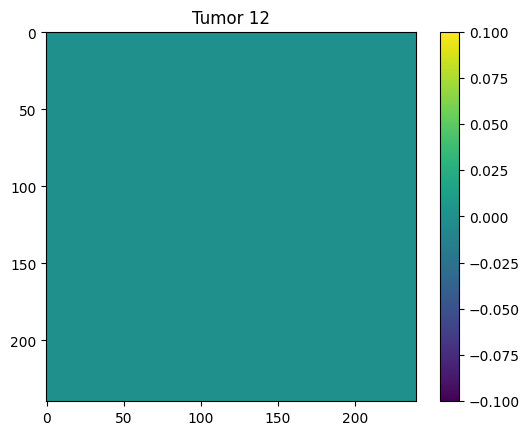

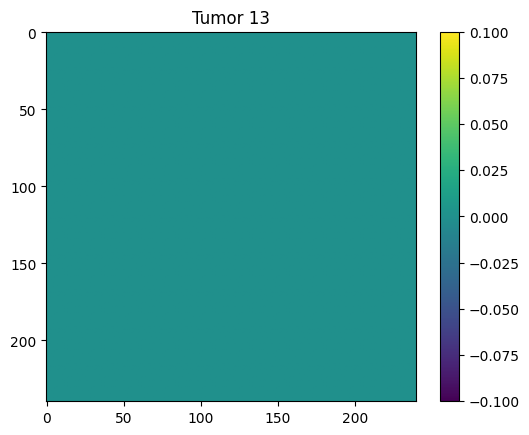

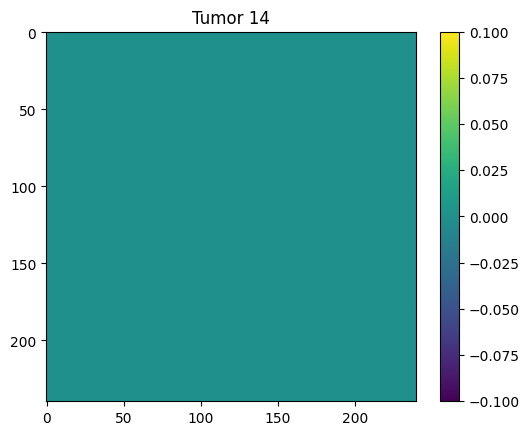

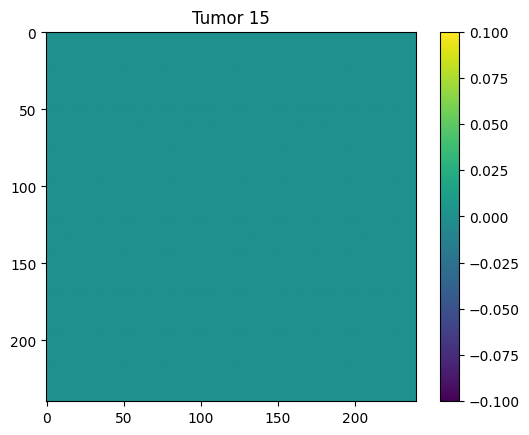

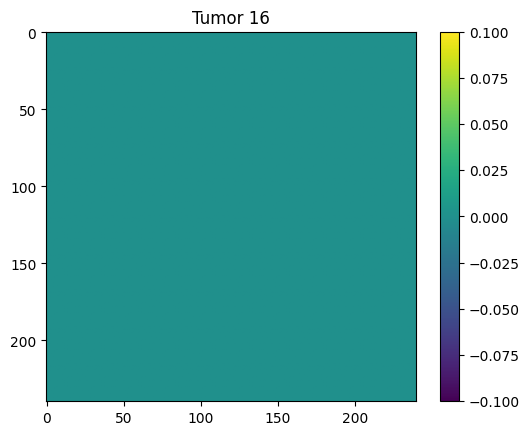

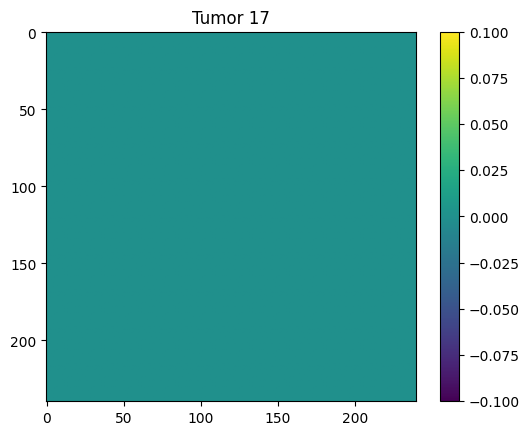

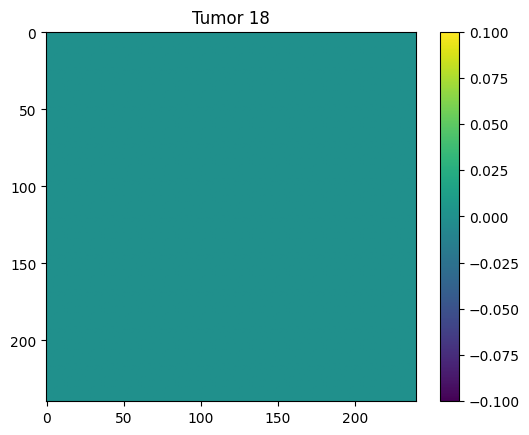

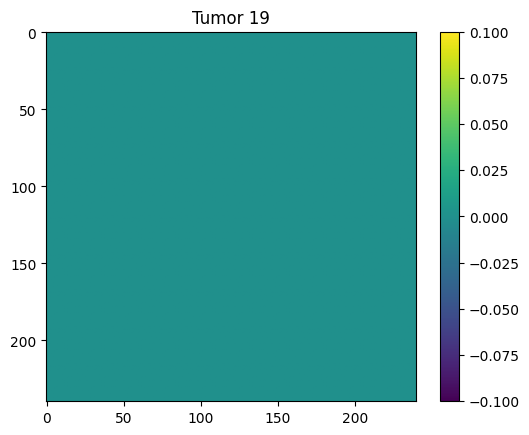

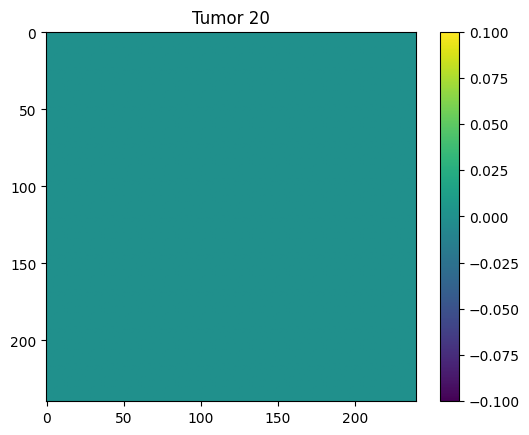

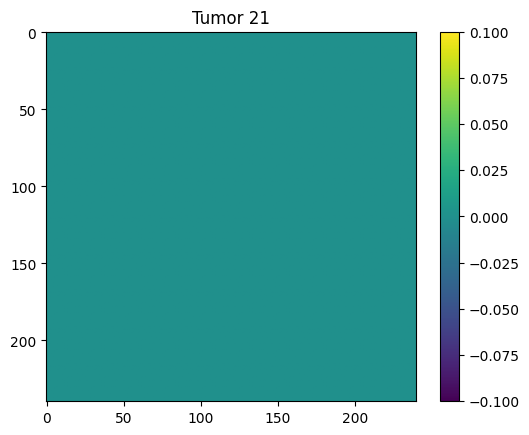

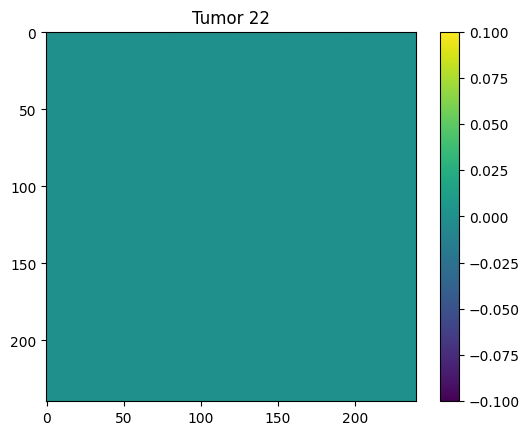

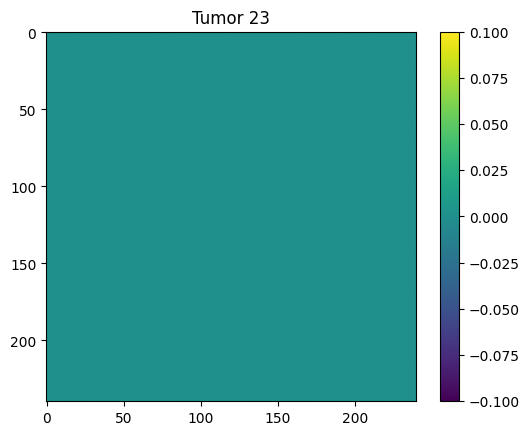

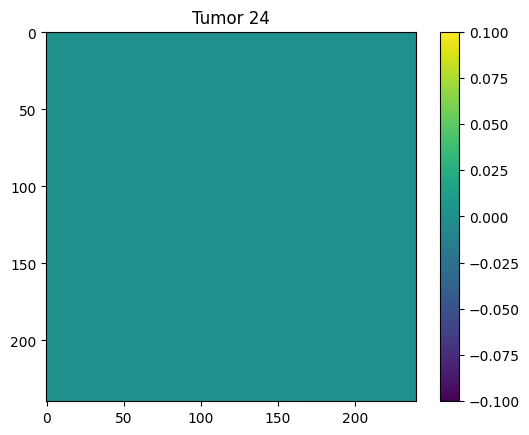

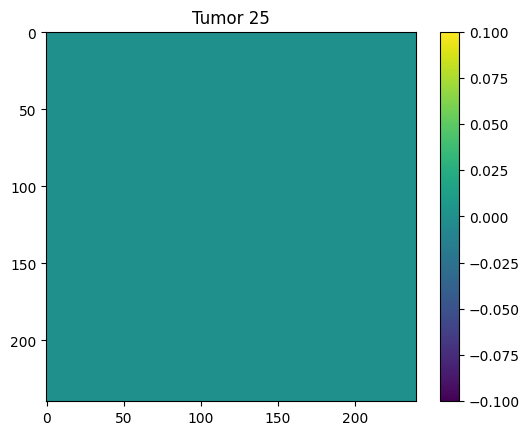

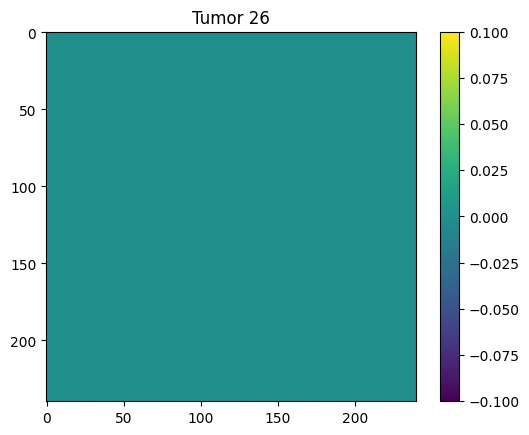

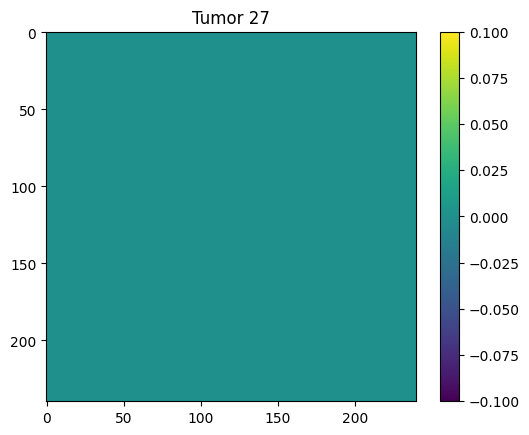

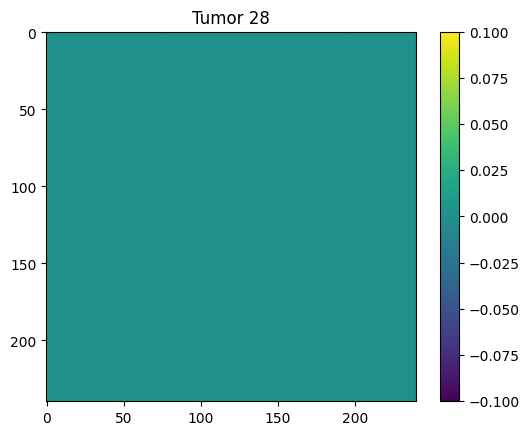

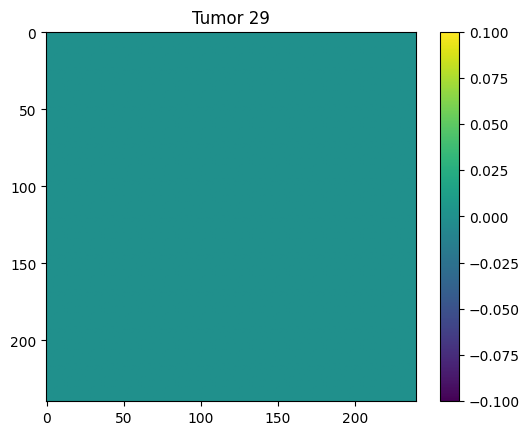

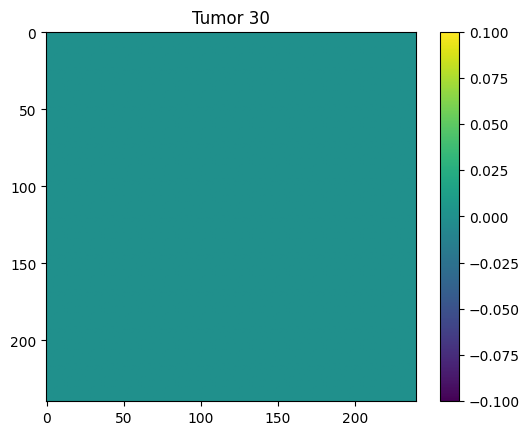

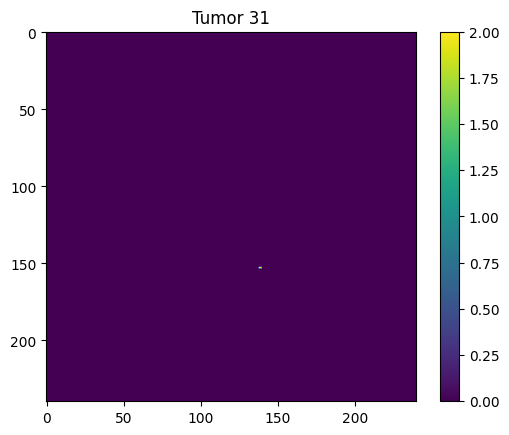

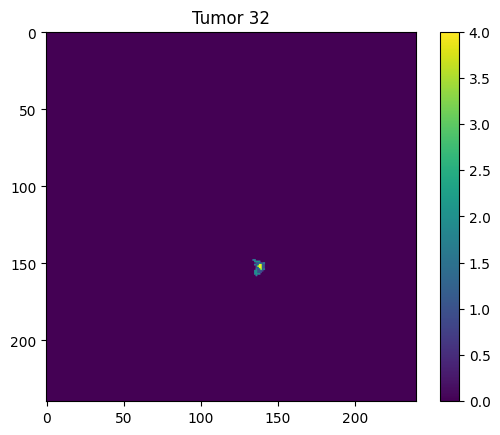

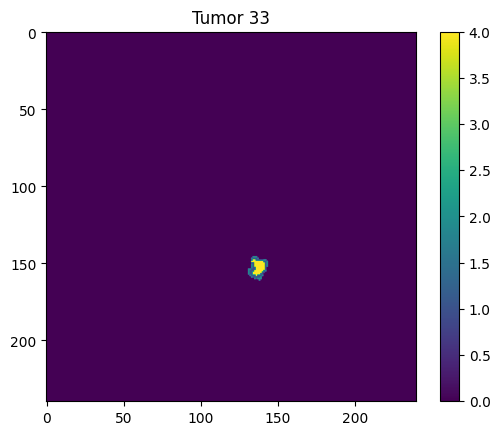

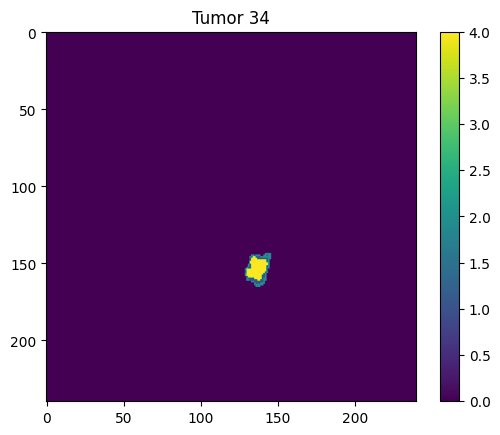

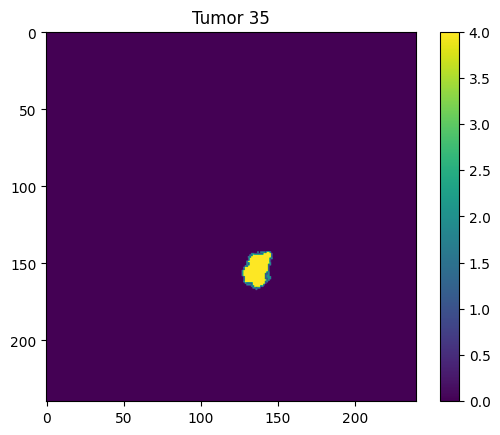

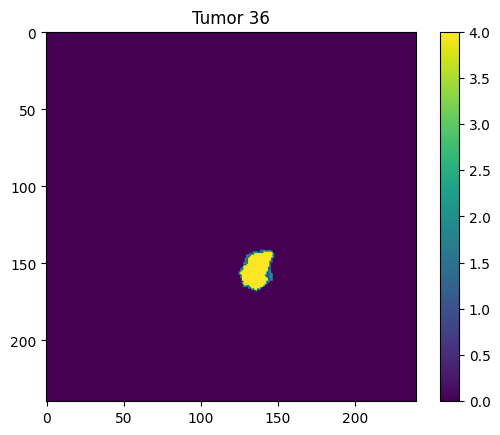

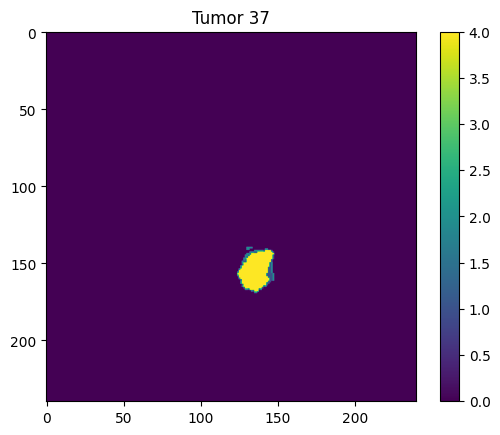

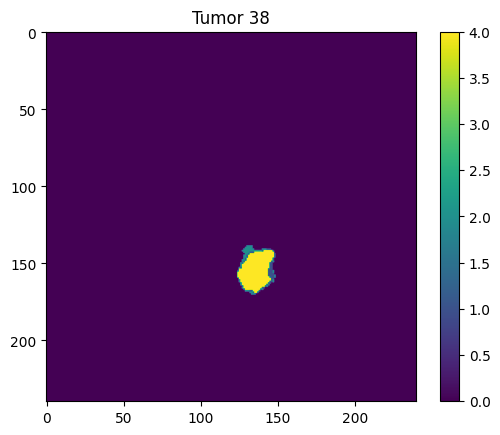

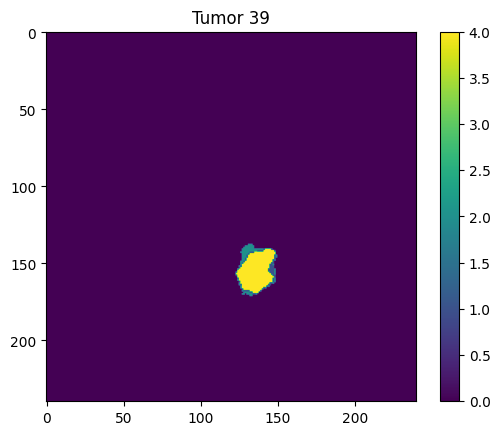

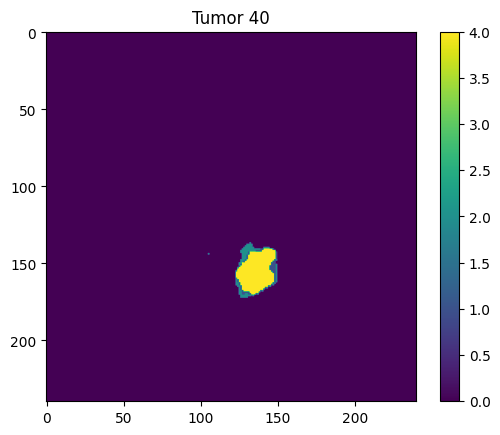

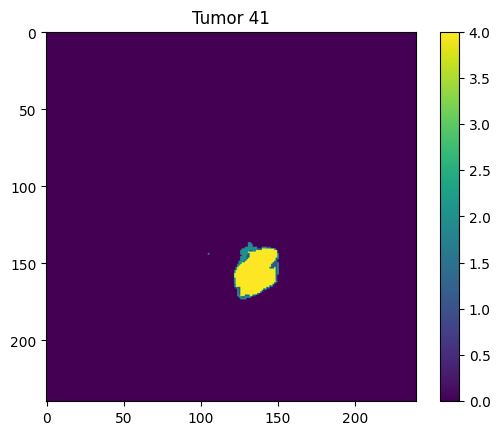

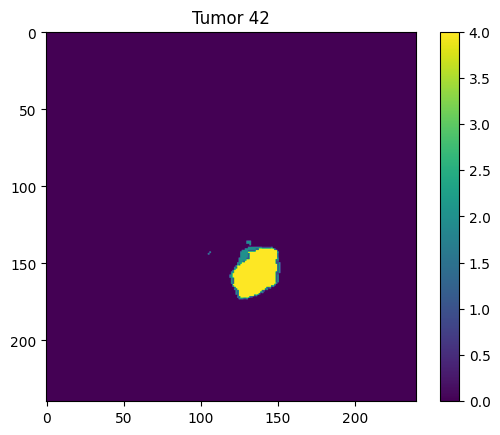

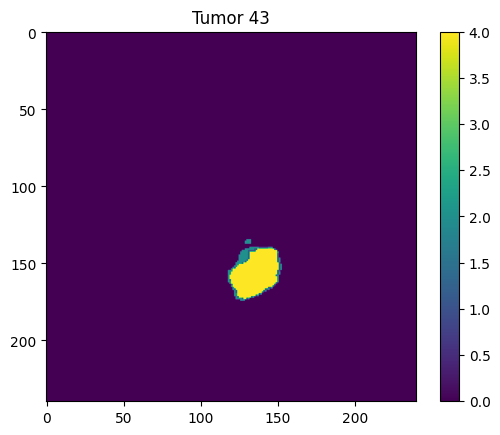

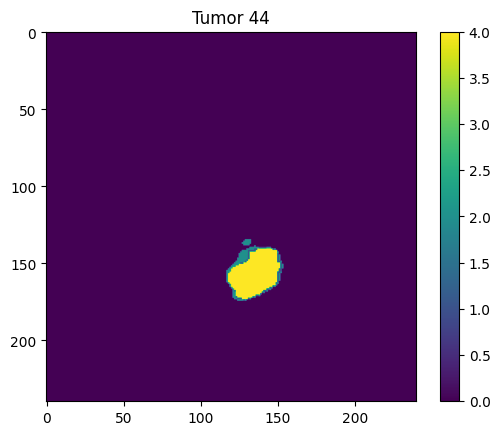

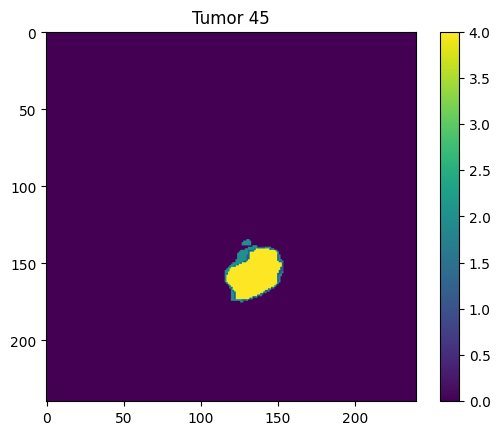

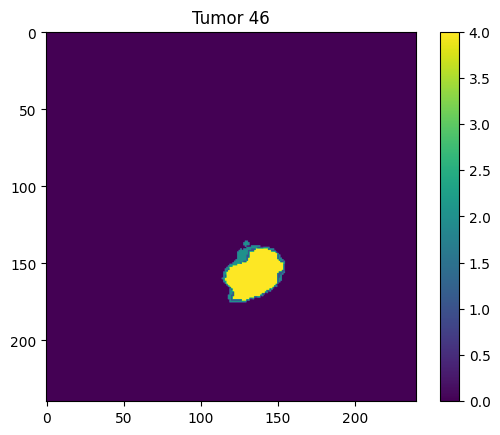

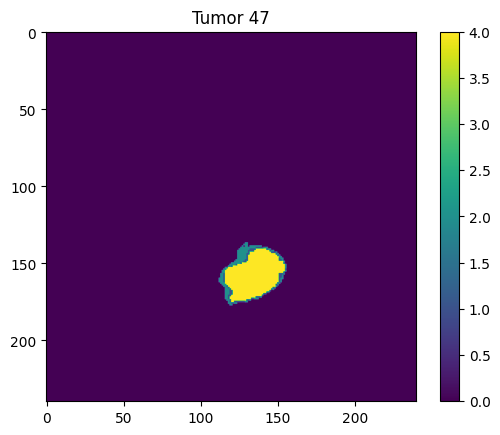

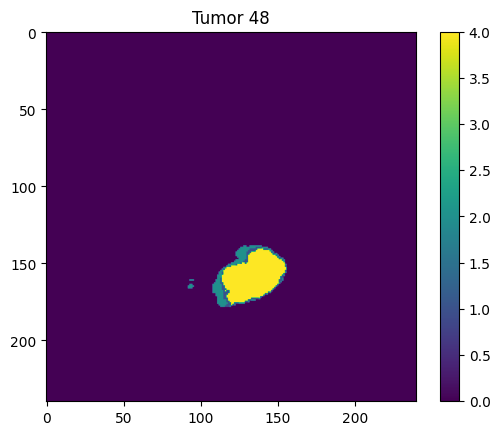

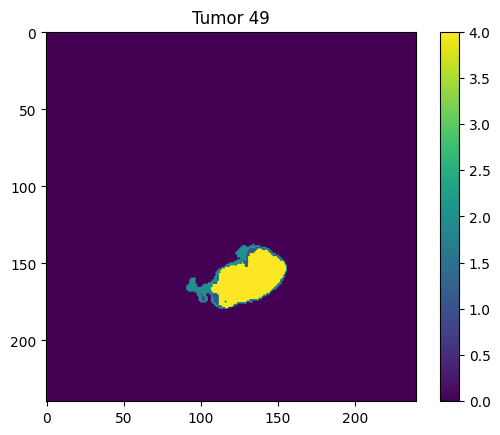

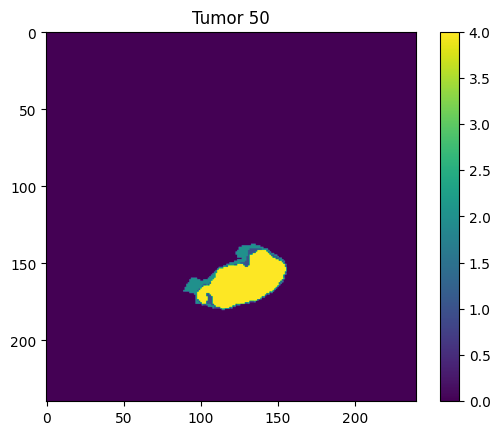

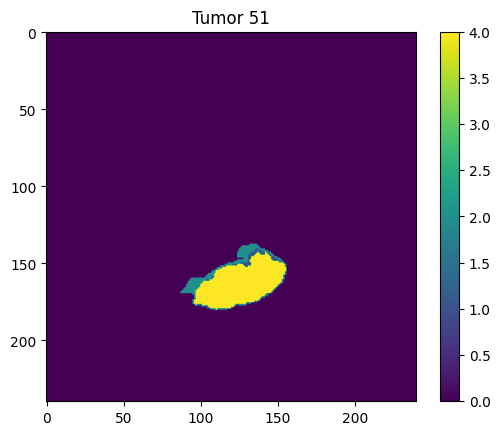

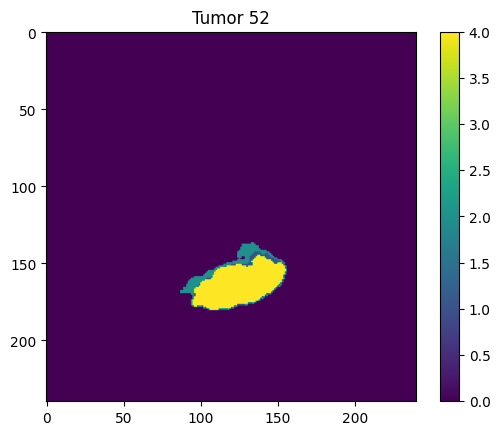

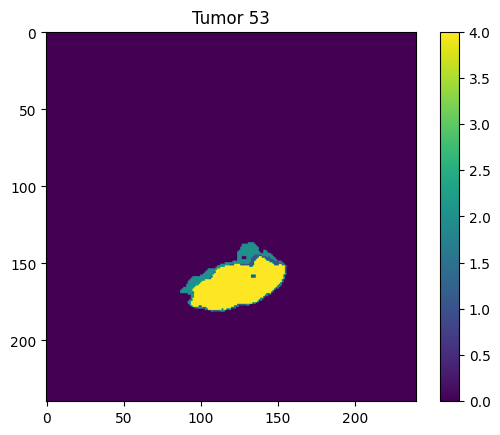

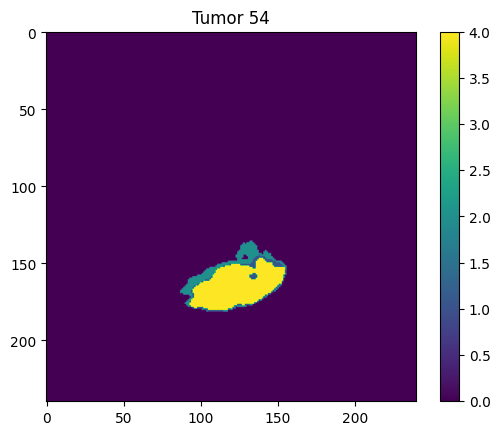

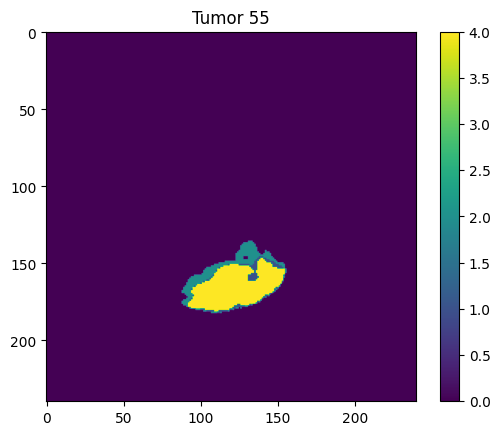

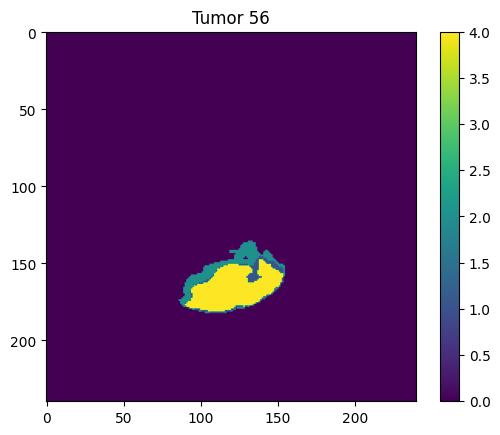

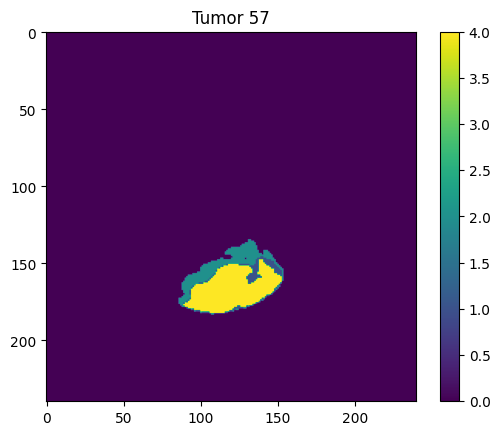

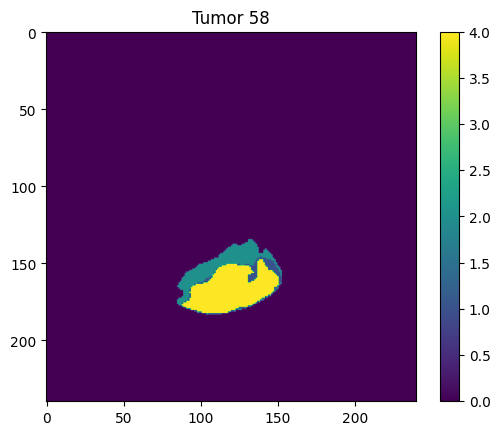

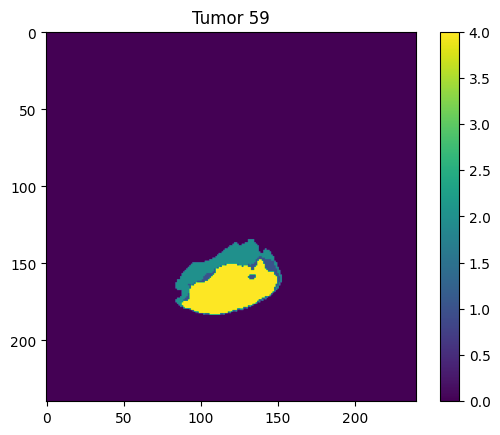

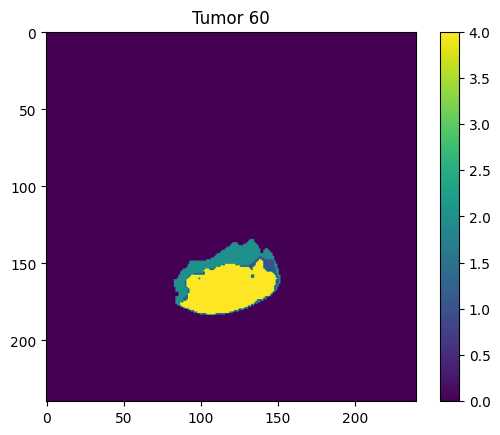

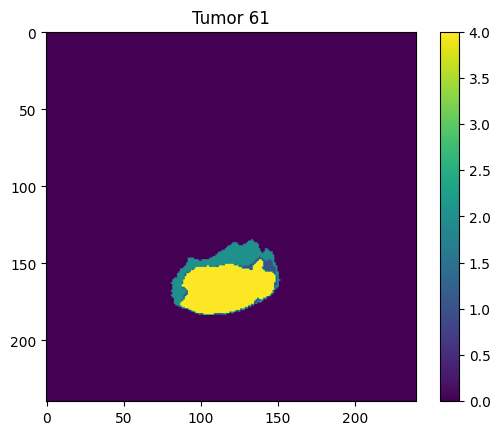

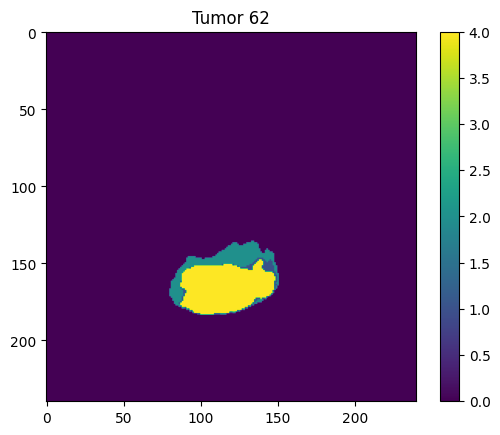

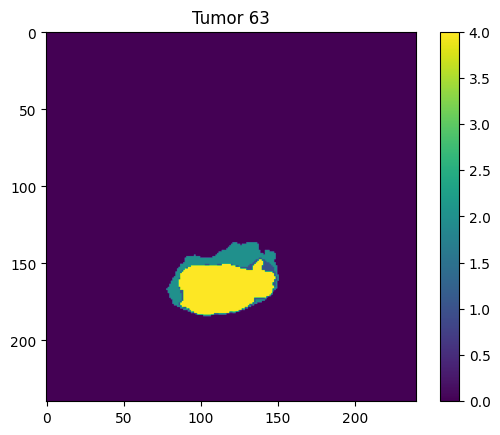

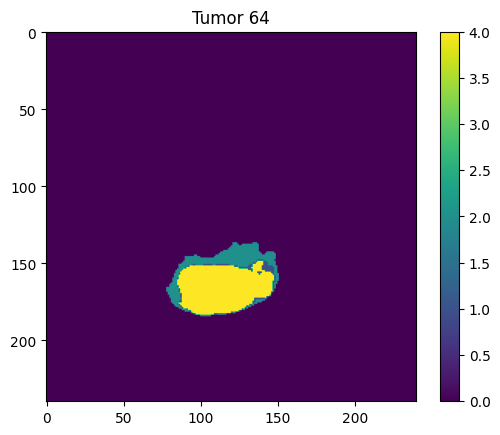

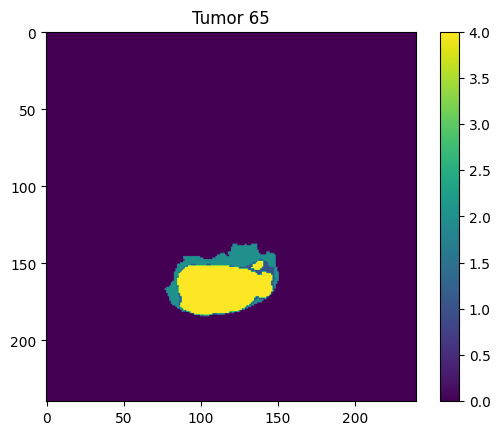

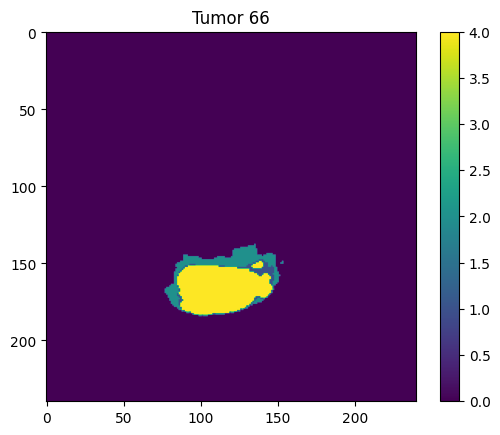

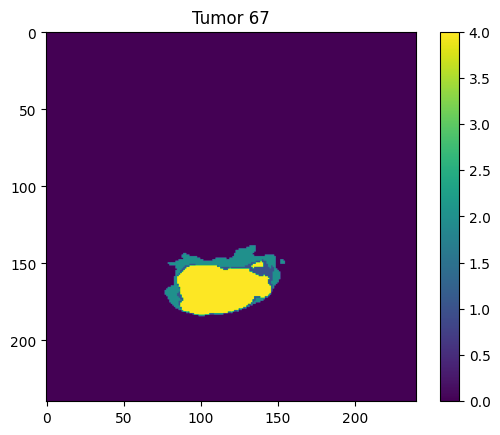

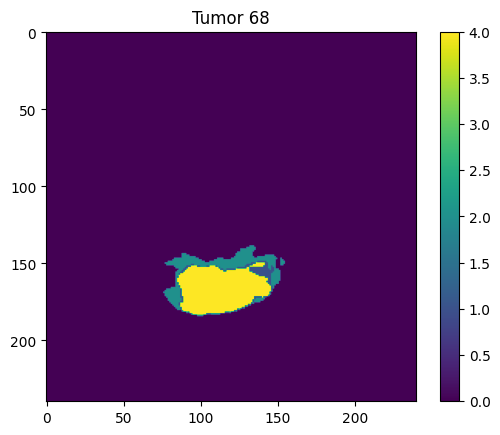

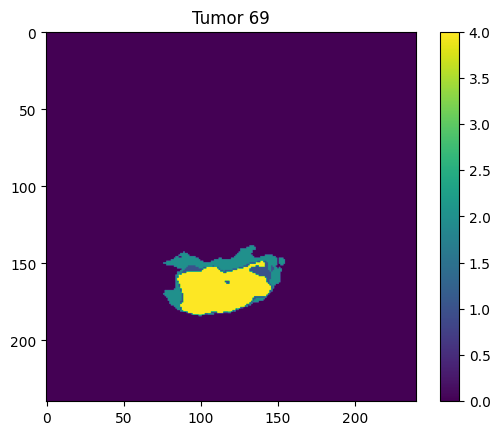

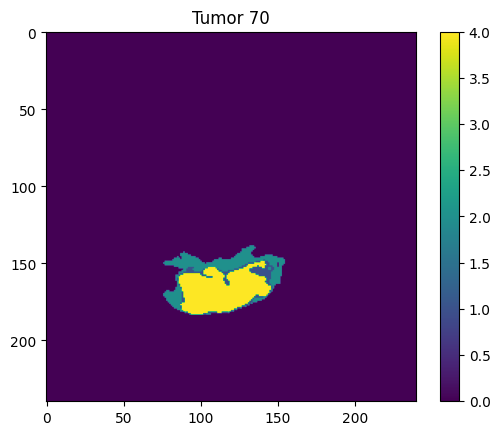

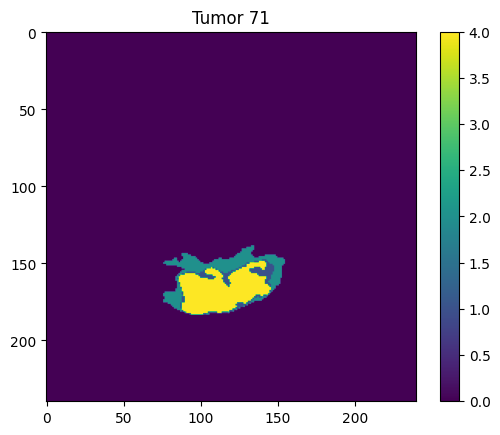

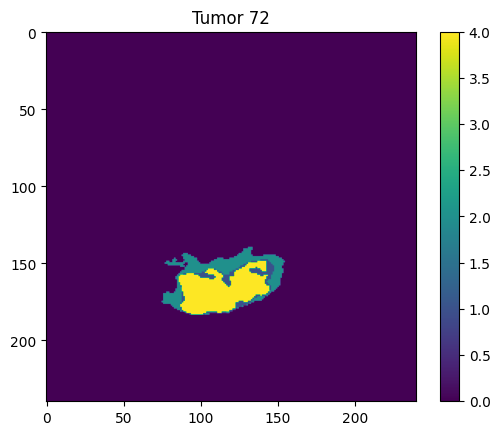

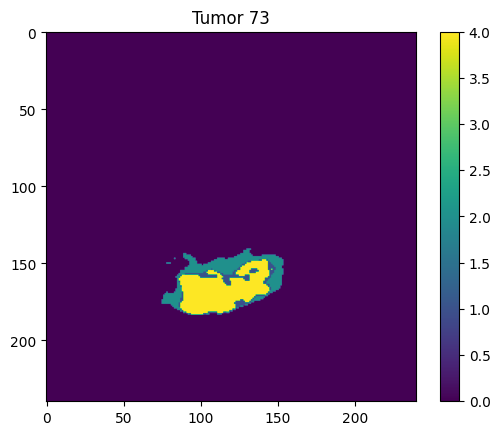

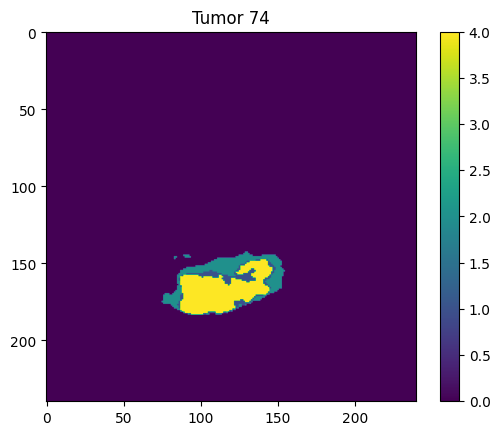

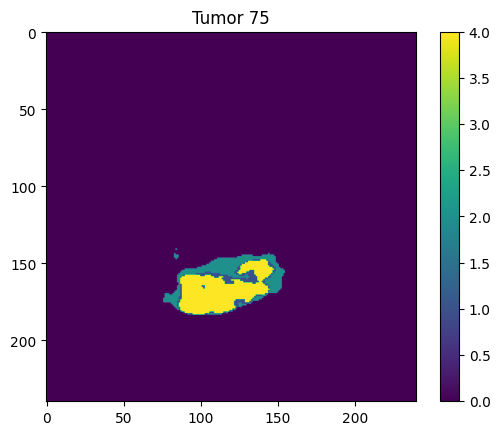

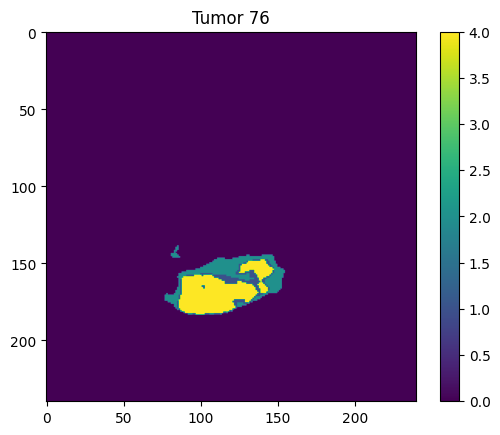

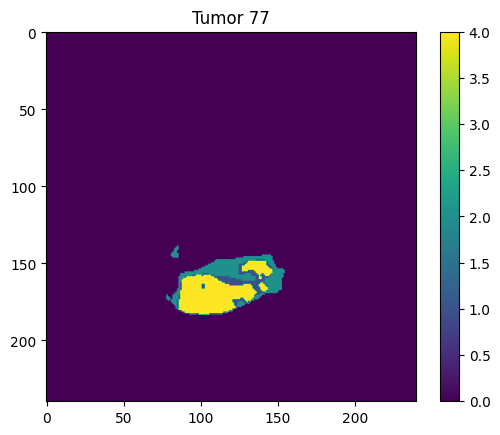

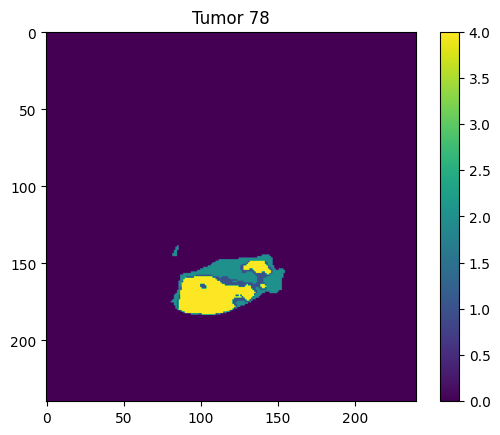

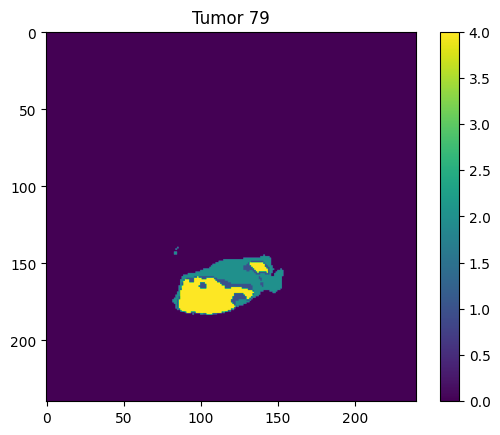

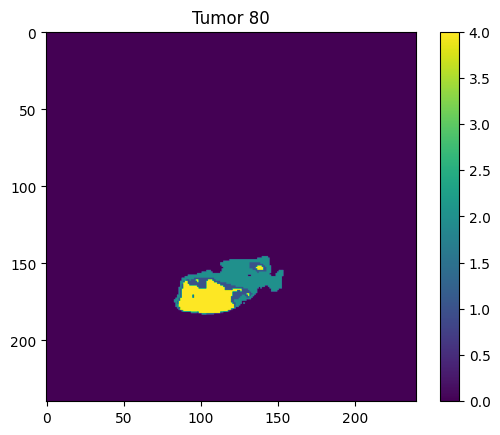

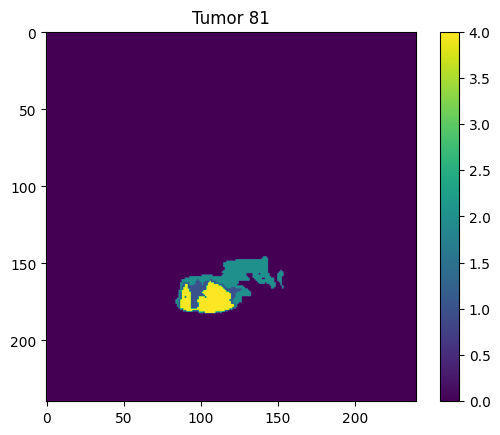

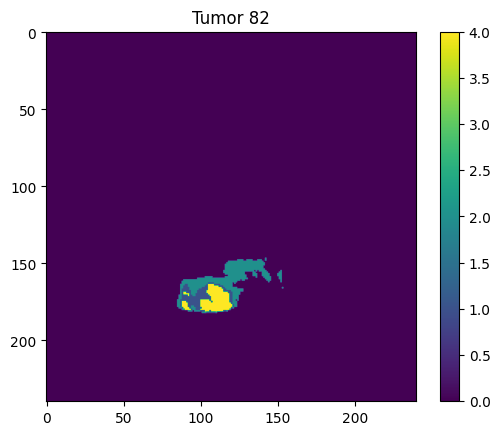

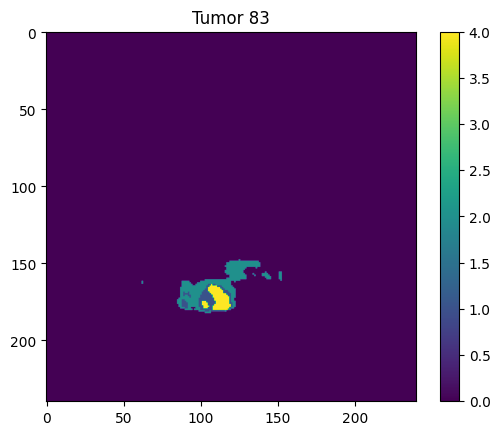

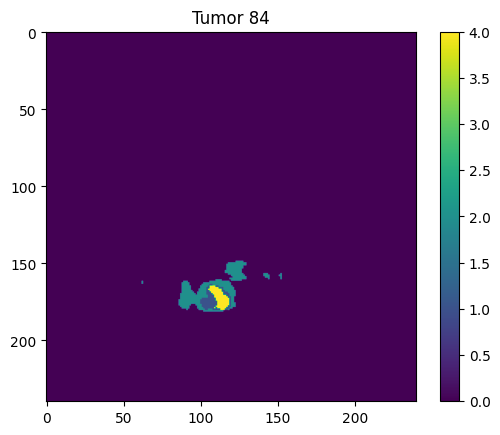

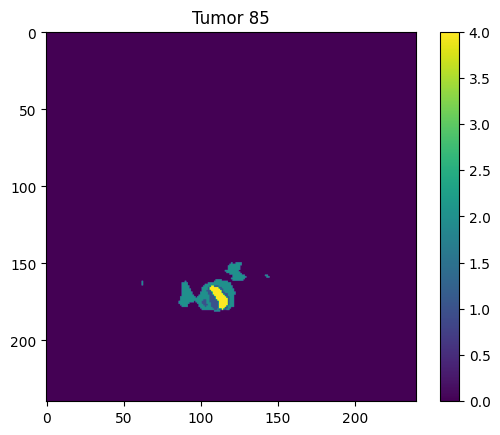

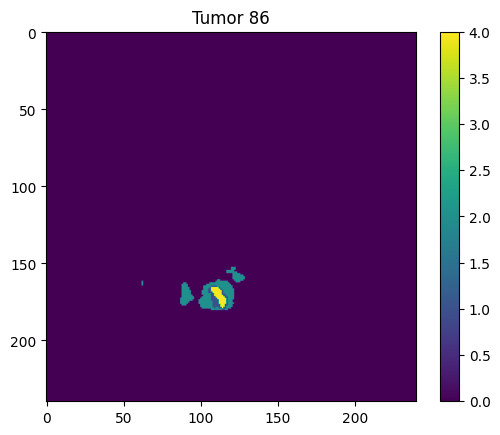

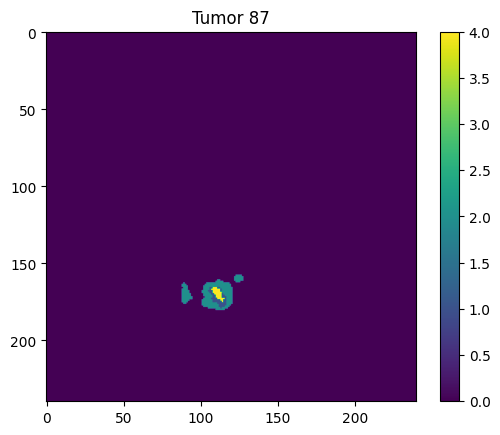

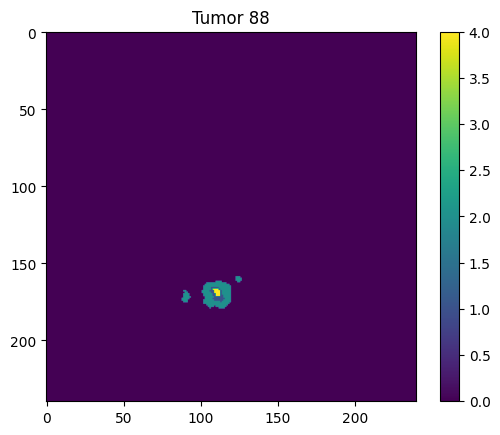

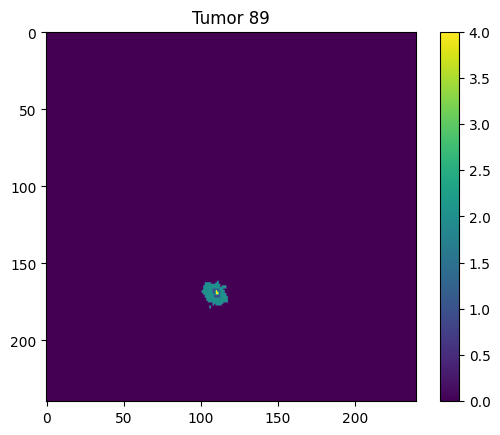

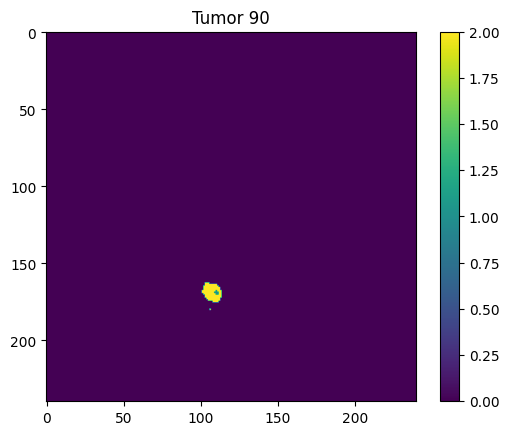

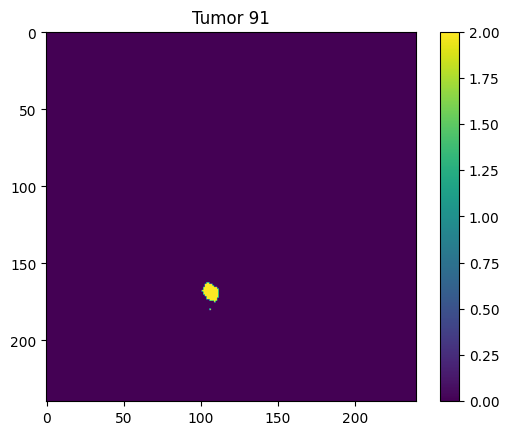

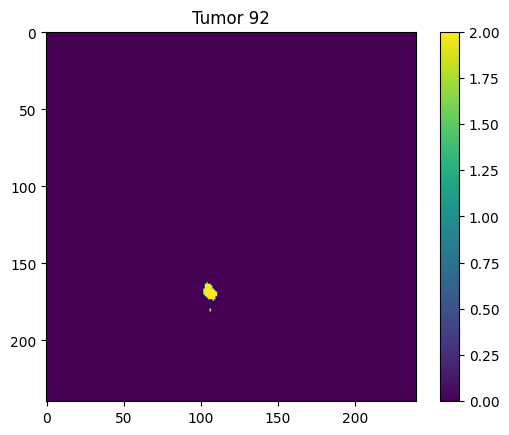

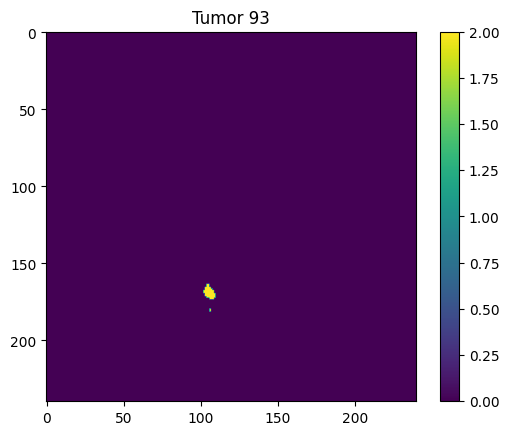

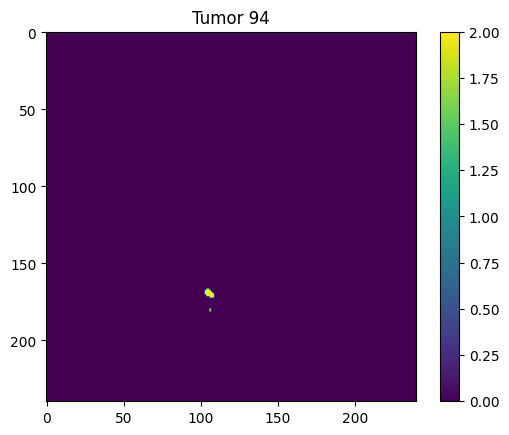

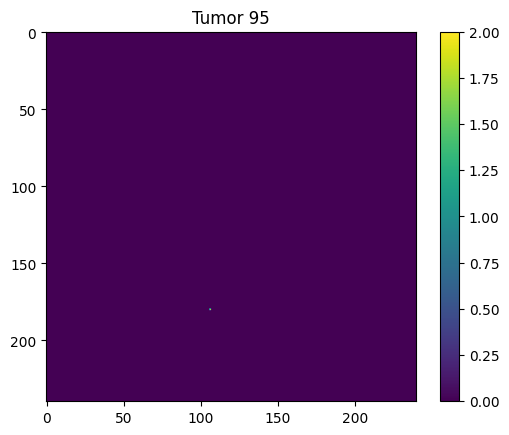

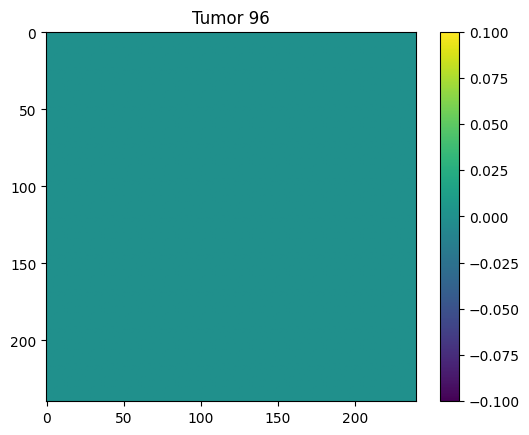

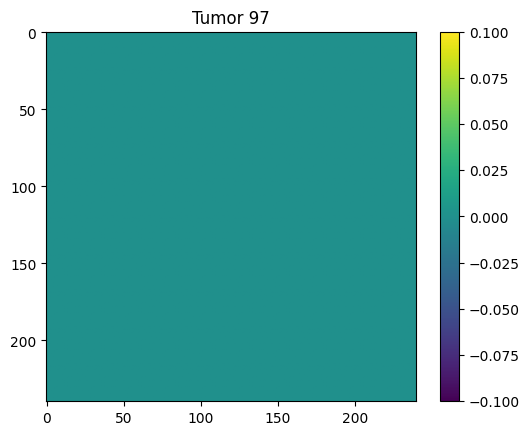

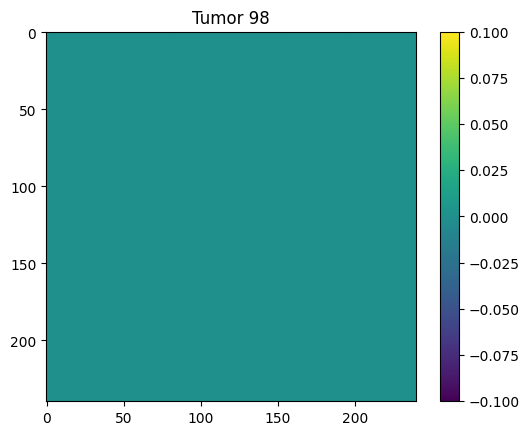

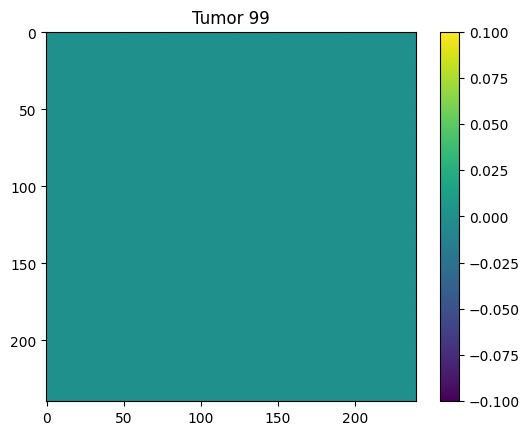

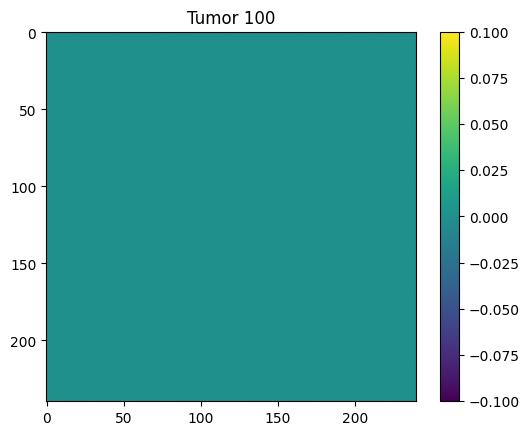

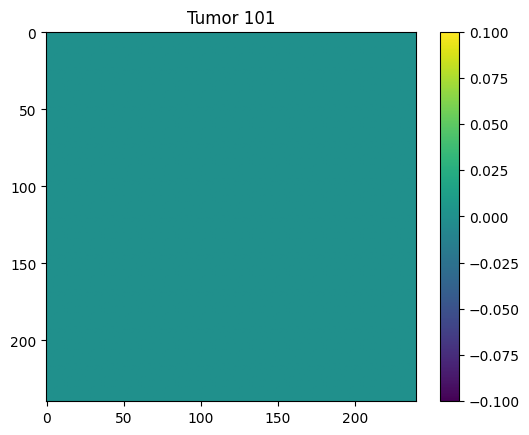

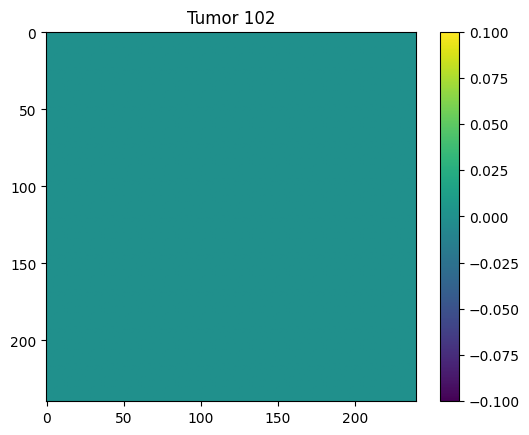

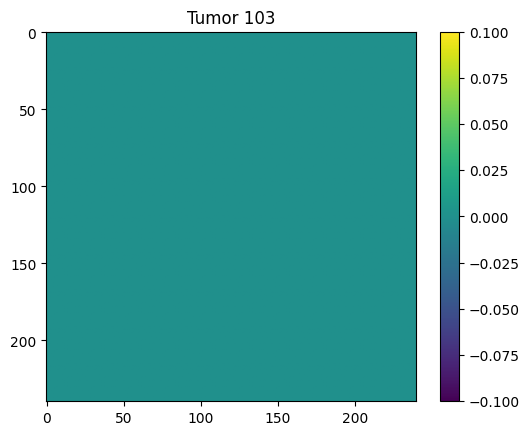

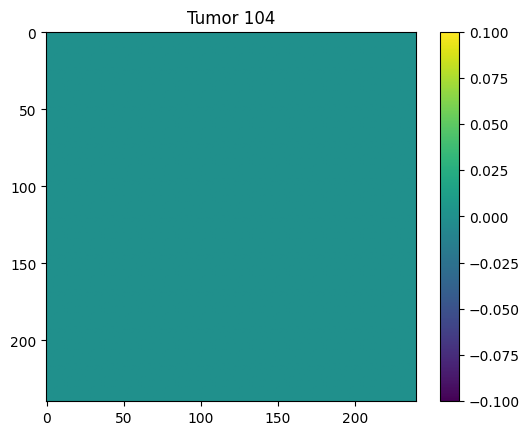

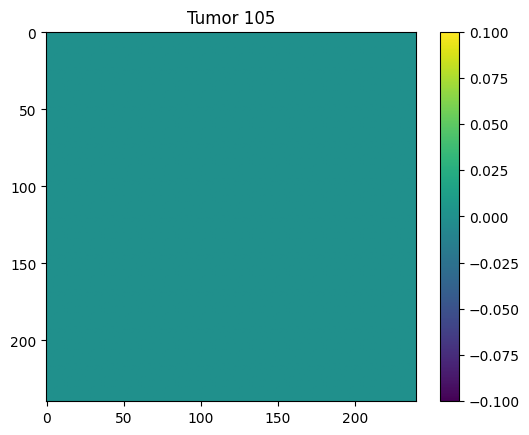

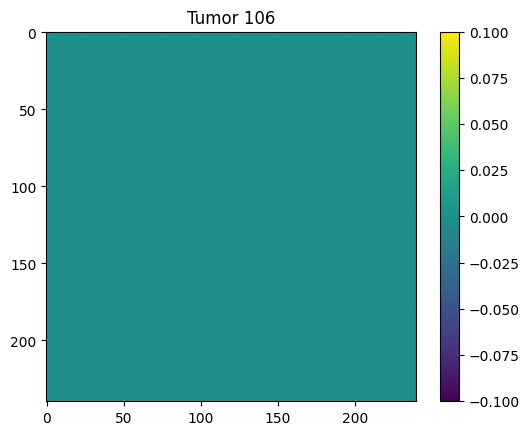

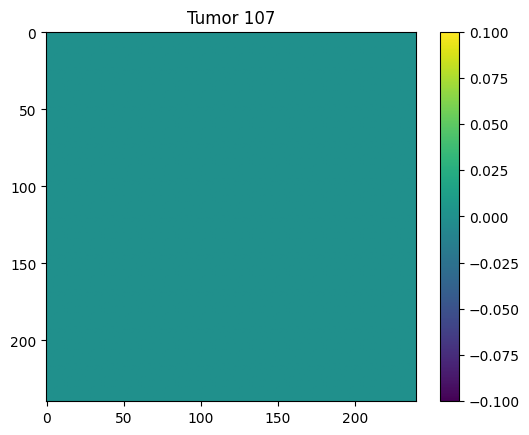

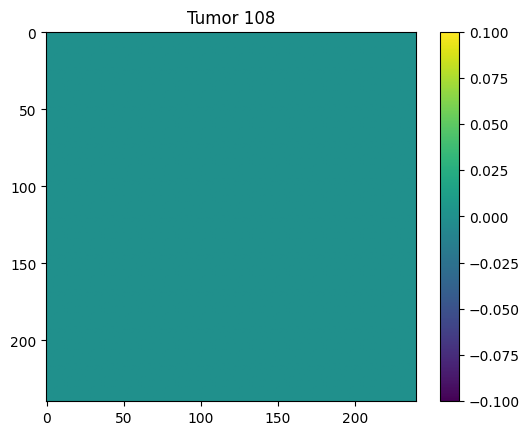

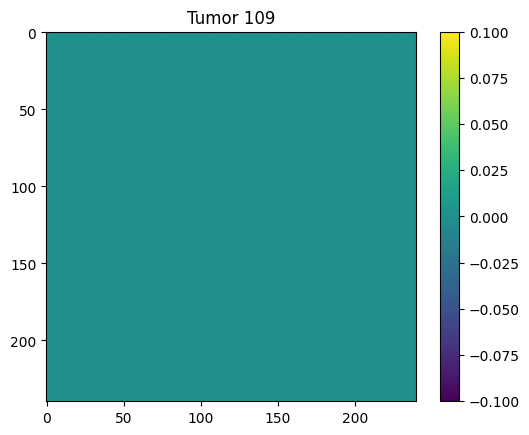

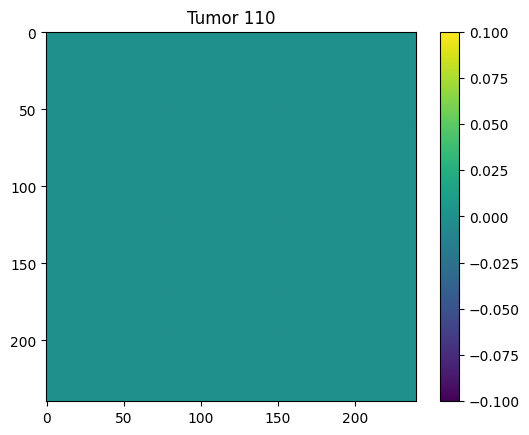

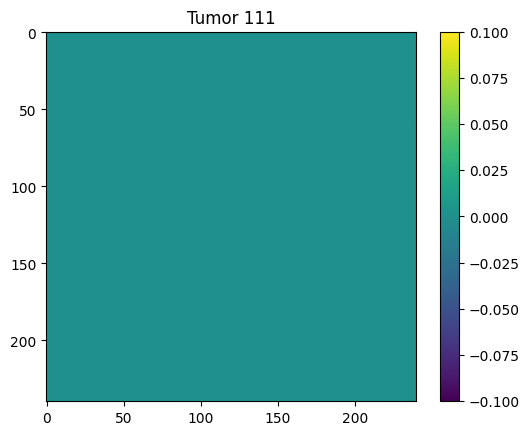

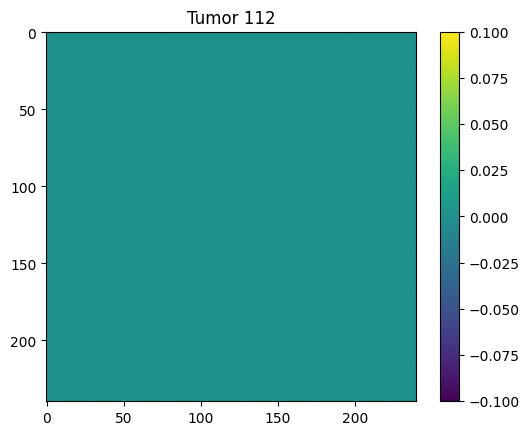

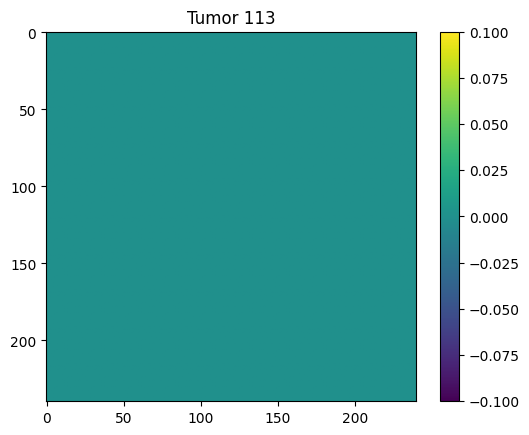

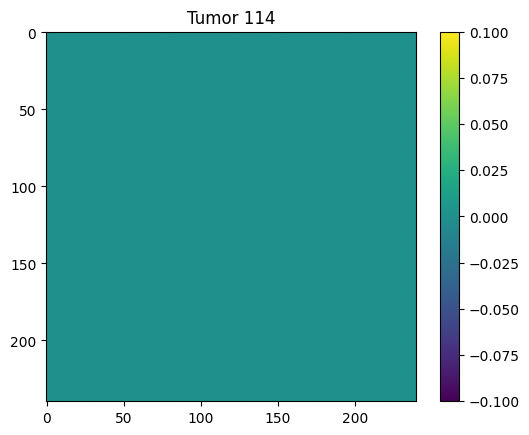

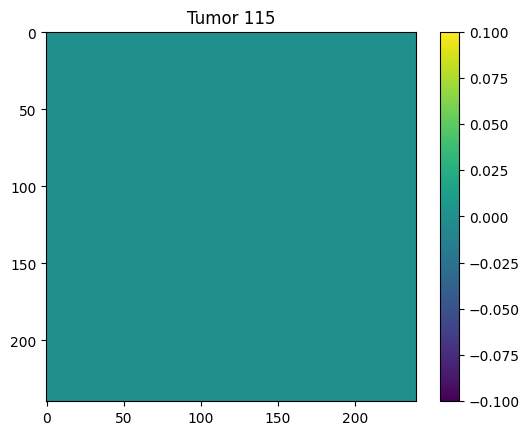

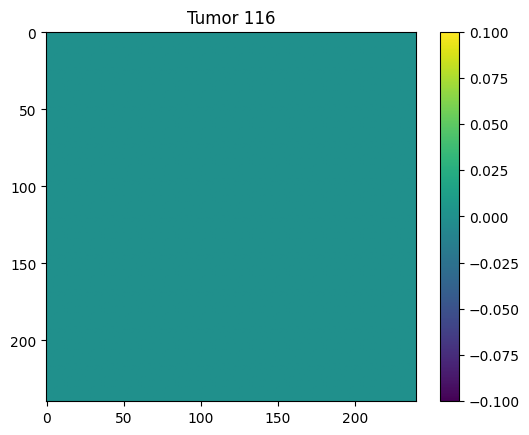

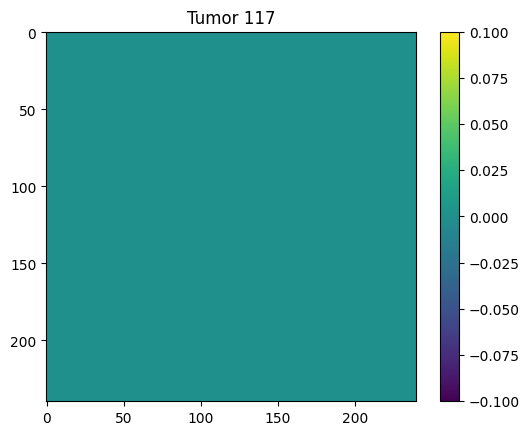

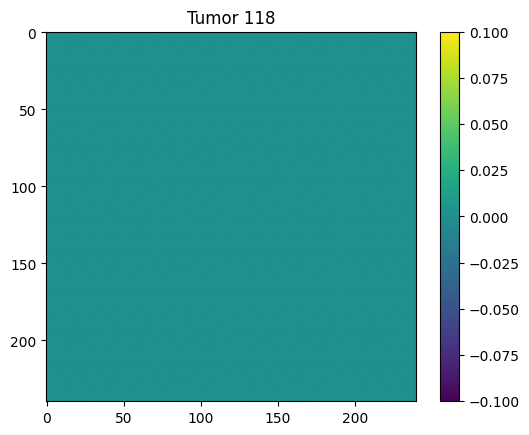

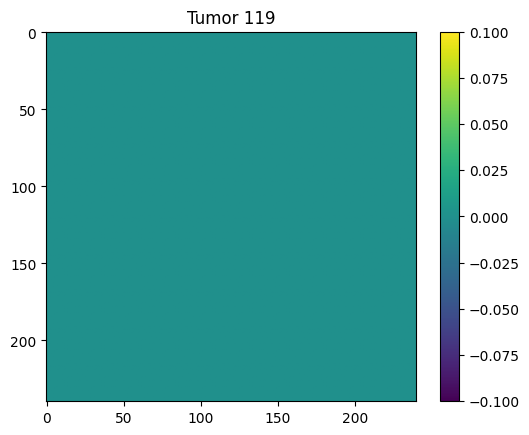

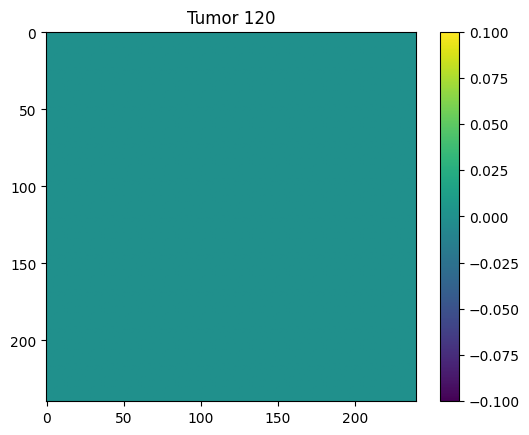

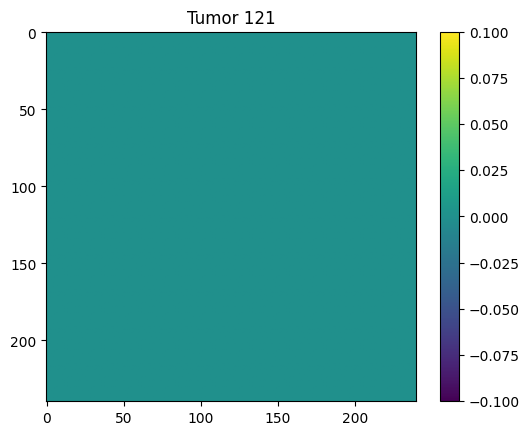

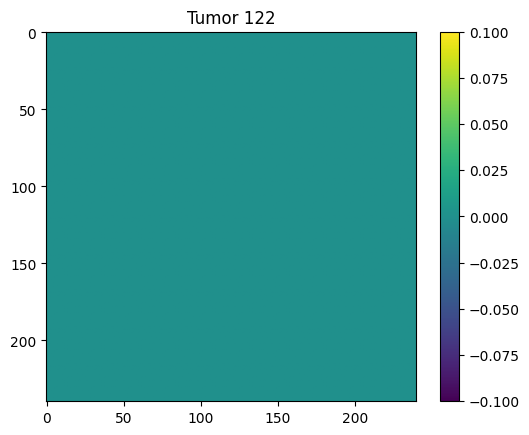

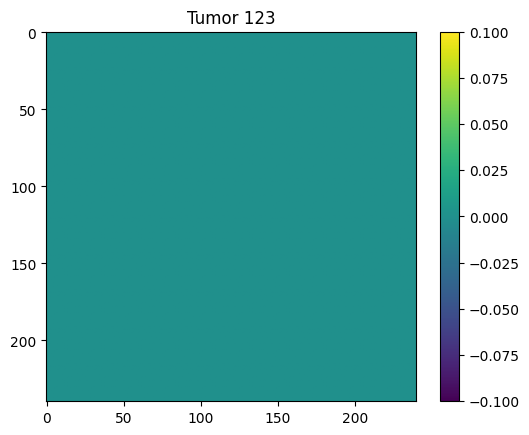

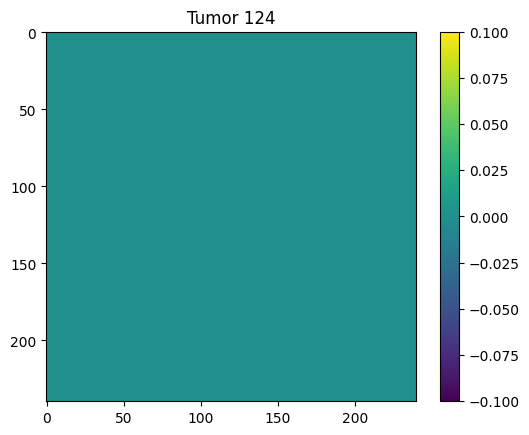

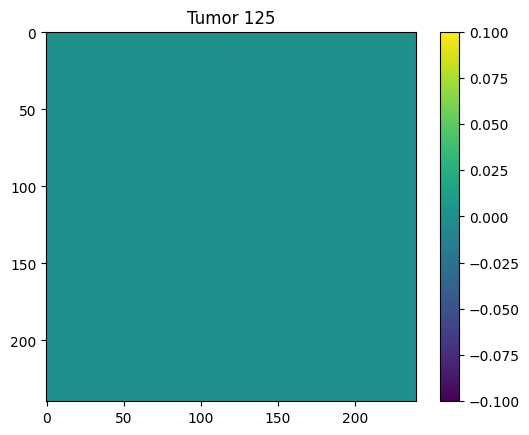

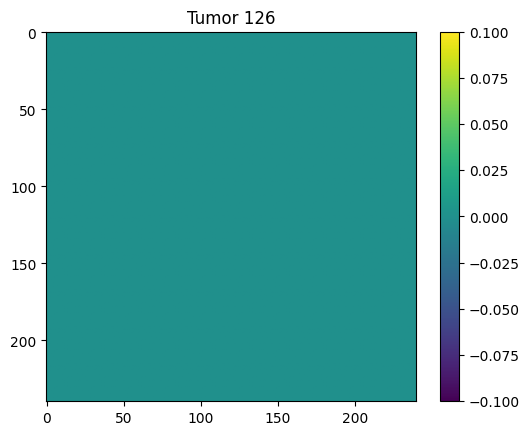

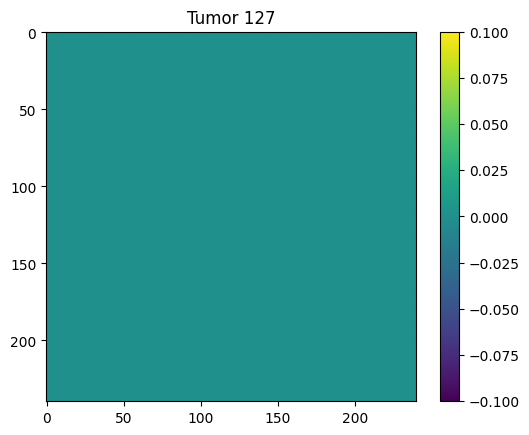

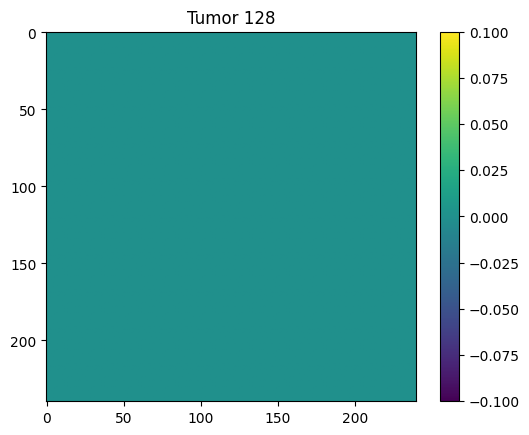

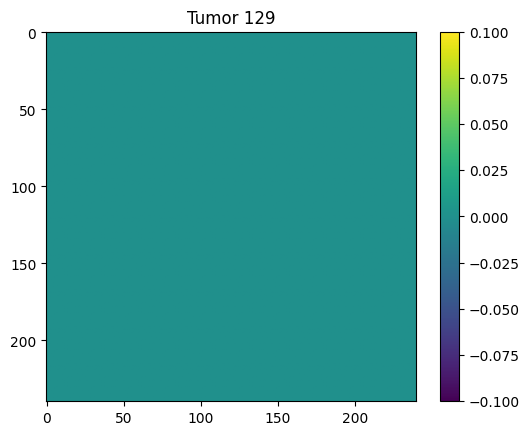

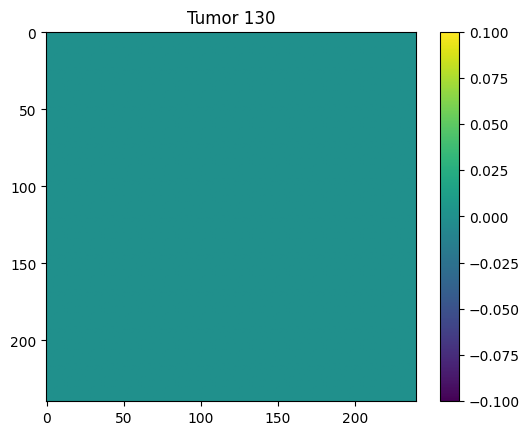

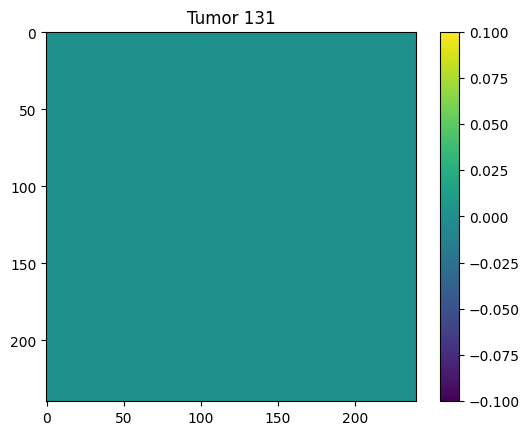

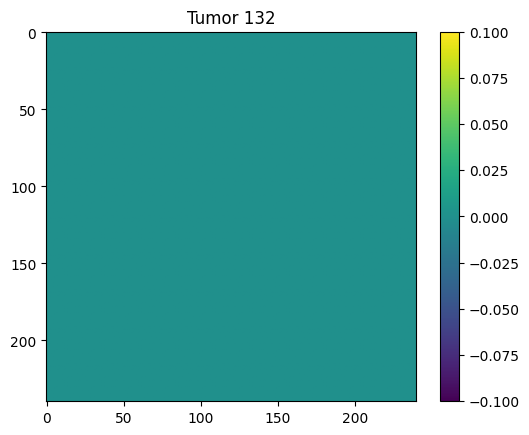

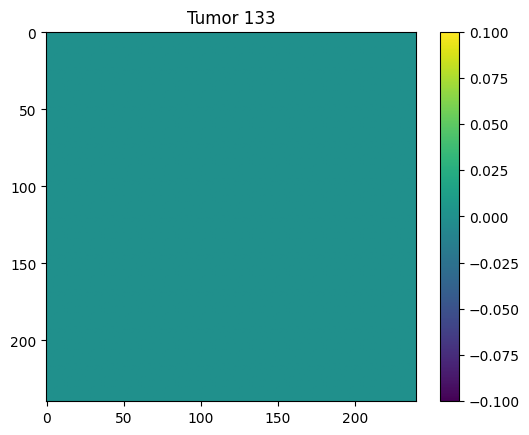

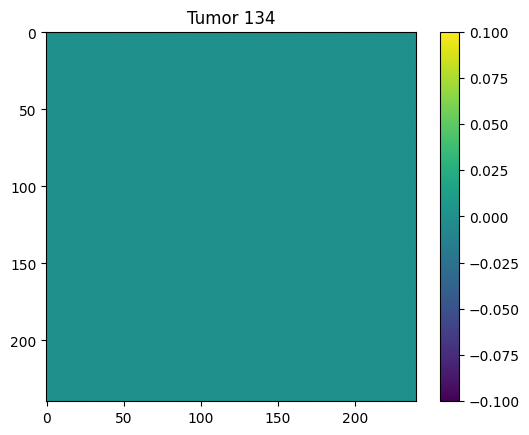

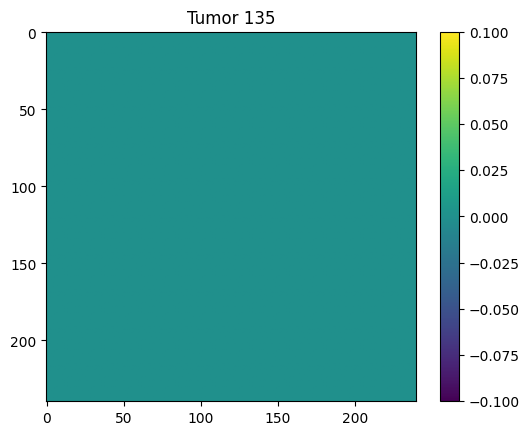

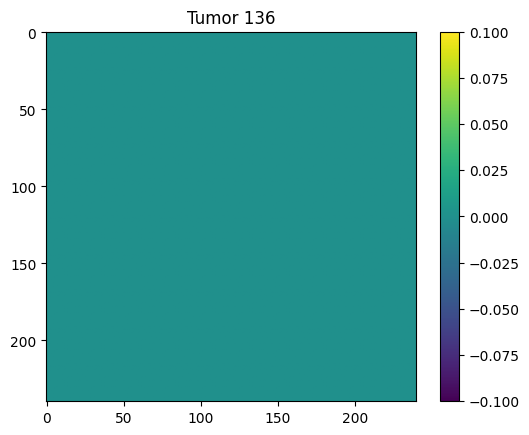

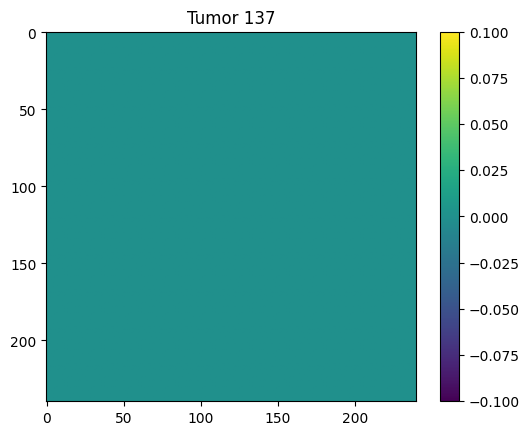

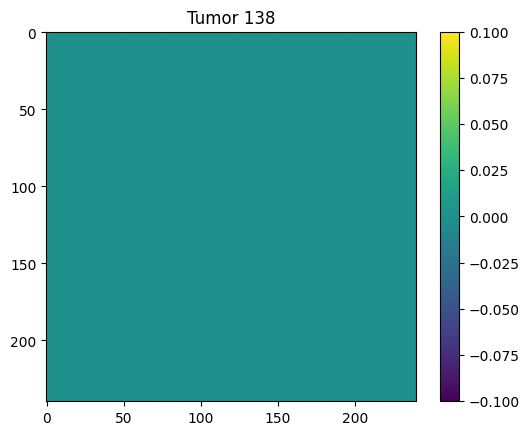

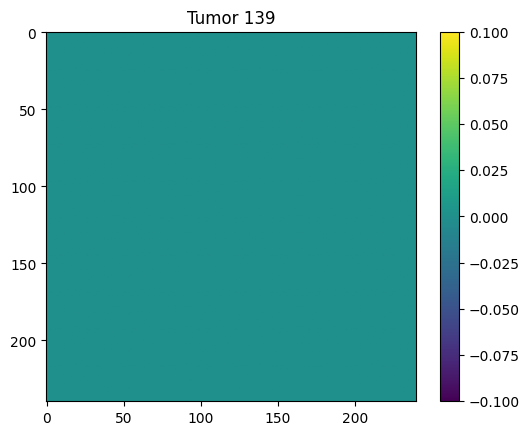

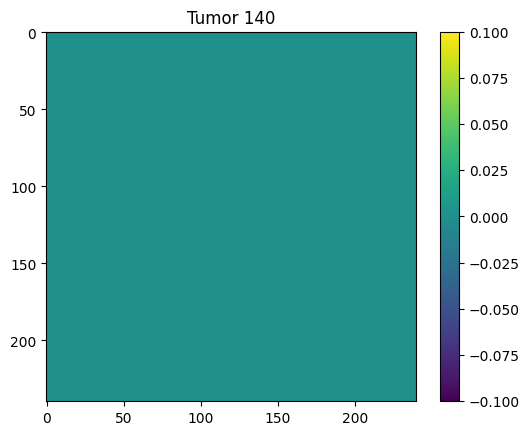

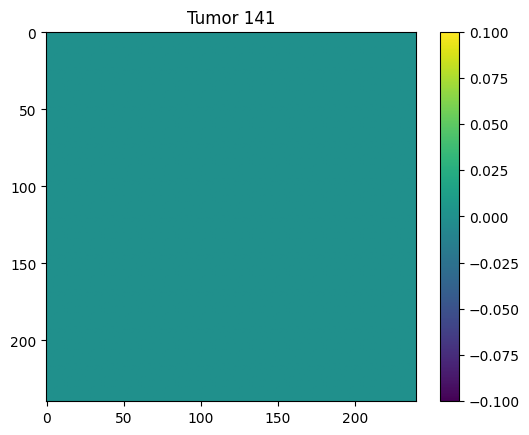

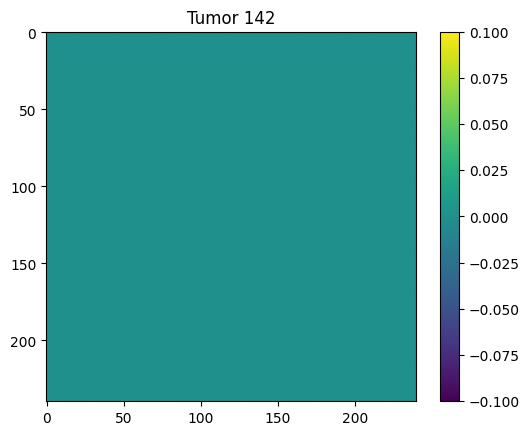

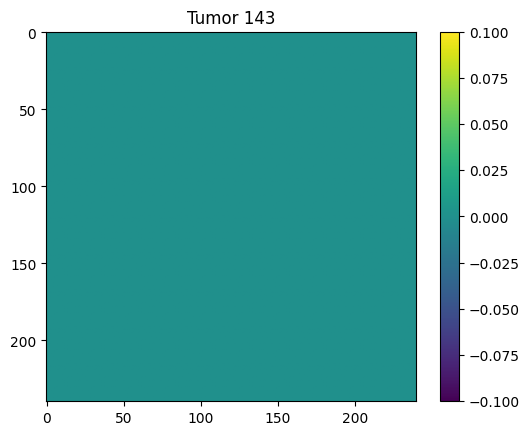

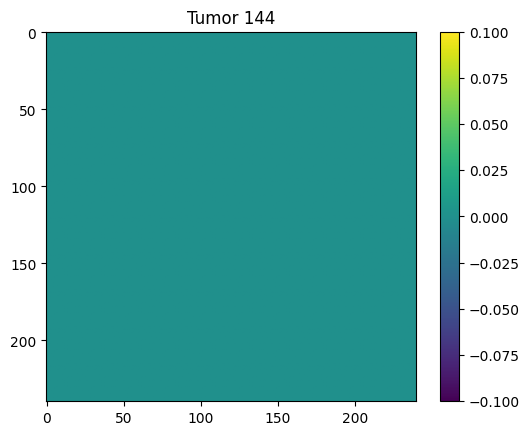

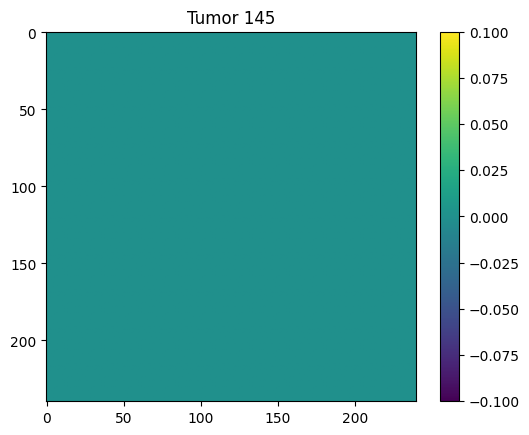

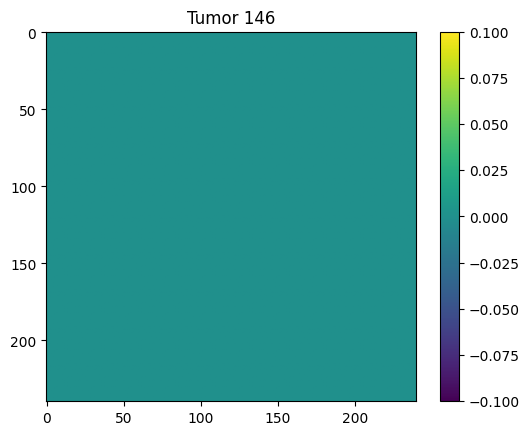

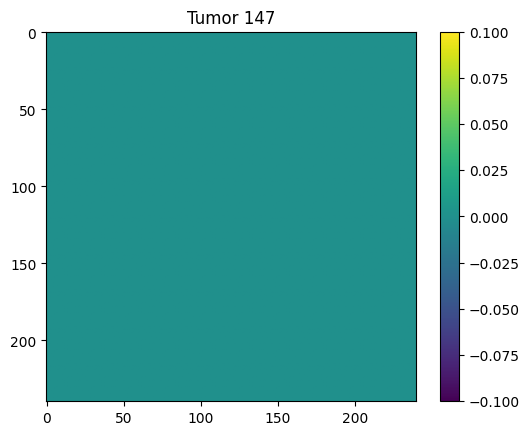

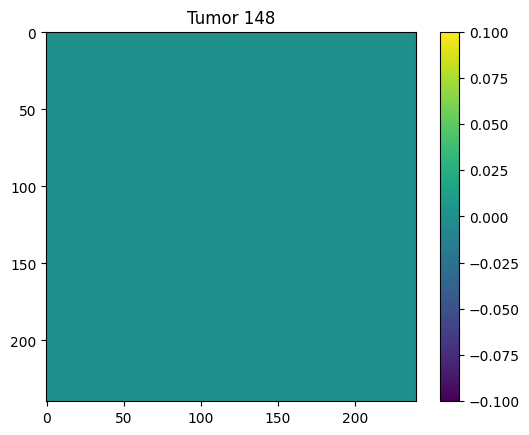

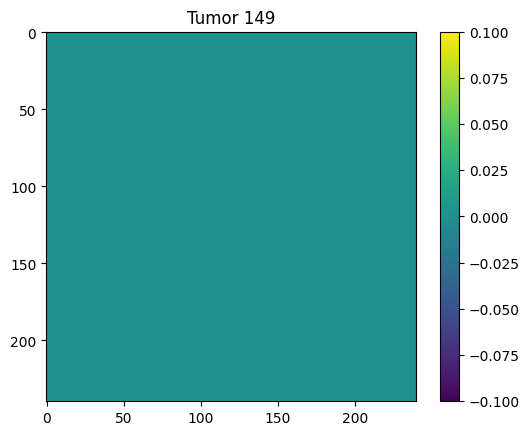

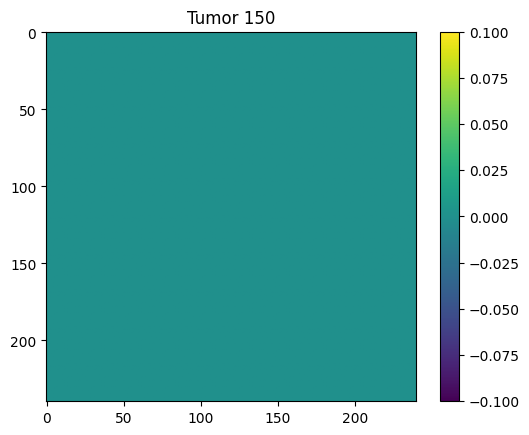

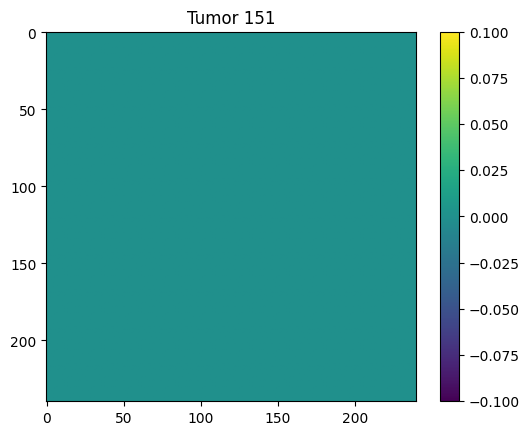

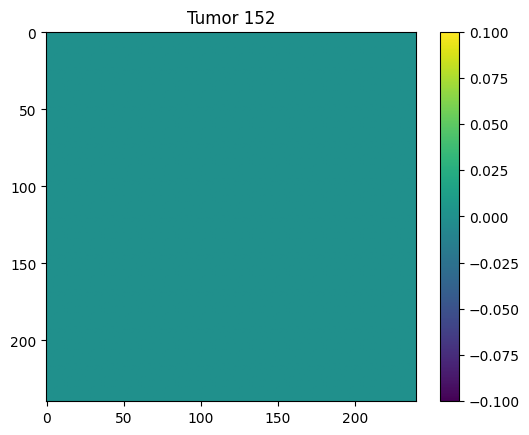

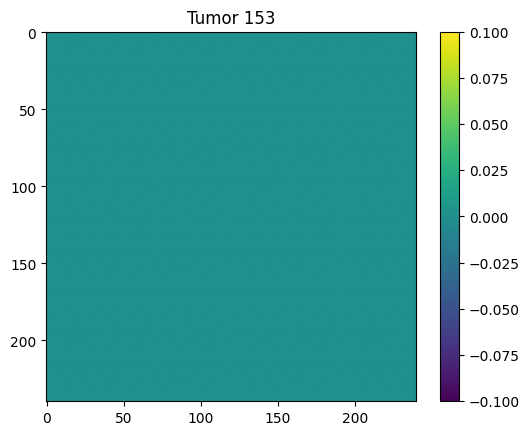

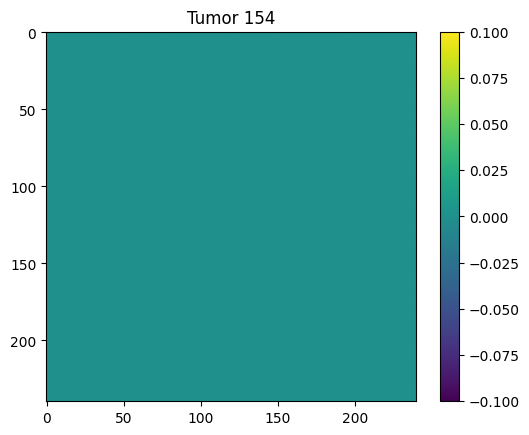

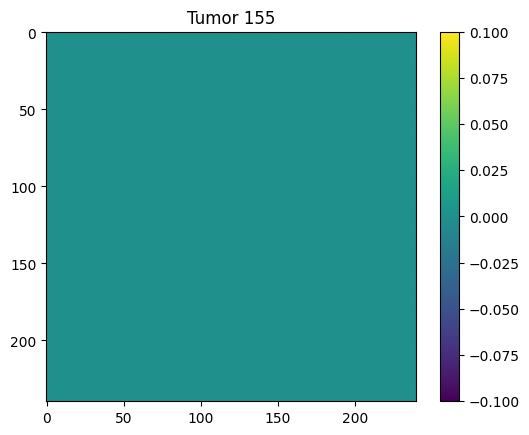

In [ ]:

# Load the NIfTI image
nifti_img = nib.load('/content/monai_results/BRATS_035/BRATS_035_seg.nii.gz')

# Extract the image data as a NumPy array
img_data = nifti_img.get_fdata()

# Number of channels (tumors)
num_channels = img_data.shape[-1]

# Display each channel (tumor) with a unique colormap
for i in range(num_channels):
    tumor_channel = img_data[..., i]  # Extract the i-th channel
    plt.imshow(tumor_channel, cmap='viridis')  # Use a different colormap for each tumor
    plt.title(f'Tumor {i + 1}')
    plt.colorbar()
    plt.show()


### Using MONAI to visualise slices

In [ ]:
!pip install itk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 31.6 MB/s eta 0:00:00


In [ ]:
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 11.1 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import SimpleITK as sitk  # noqa: N813
import numpy as np
import itk
import tempfile
import monai
from monai.data import PILReader
from monai.transforms import LoadImage, LoadImaged, Resized, Compose, SaveImage
from monai.config import print_config

print_config()

MONAI version: 1.3.dev2336
Numpy version: 1.23.5
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 697f3ecbe9c7743e47778c13e4604ed225a3b1fd
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.10.1
Pillow version: 9.4.0
Tensorboard version: 2.12.3
gdown version: 4.6.6
TorchVision version: 0.15.2+cu118
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit

In [ ]:
file_path='/content/drive/MyDrive/monai_results/BRATS_035/BRATS_035_seg.nii.gz'

In [ ]:
data = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(file_path)
print(f"image data shape: {data.shape}")
print(f"meta data: {data.meta.keys()}")

image data shape: torch.Size([1, 240, 240, 155])
meta data: dict_keys(['sizeof_hdr', 'extents', 'session_error', 'dim_info', 'intent_p1', 'intent_p2', 'intent_p3', 'intent_code', 'datatype', 'bitpix', 'slice_start', 'vox_offset', 'scl_slope', 'scl_inter', 'slice_end', 'slice_code', 'xyzt_units', 'cal_max', 'cal_min', 'slice_duration', 'toffset', 'glmax', 'glmin', 'qform_code', 'sform_code', affine, original_affine, 'as_closest_canonical', spatial_shape, space, original_channel_dim, 'filename_or_obj'])


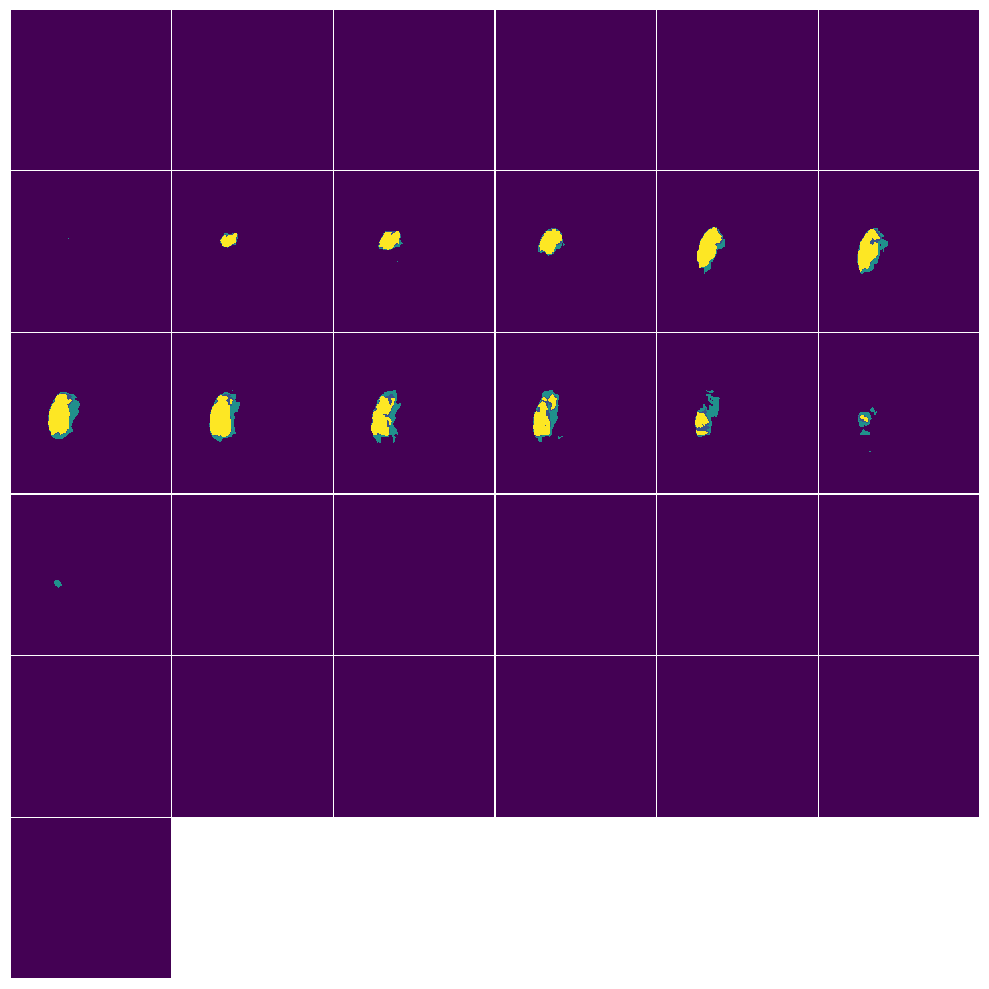

In [ ]:
fig = monai.visualize.matshow3d(monai.transforms.Orientation("SPL")(data), every_n=5)

In [ ]:
from monai.data.image_reader import NibabelReader

In [ ]:
img = LoadImage(image_only=True, reader=NibabelReader(), channel_dim=None, affine_lps_to_ras=False)(file_path)

(<Figure size 1000x1000 with 1 Axes>,
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        ...,
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32))

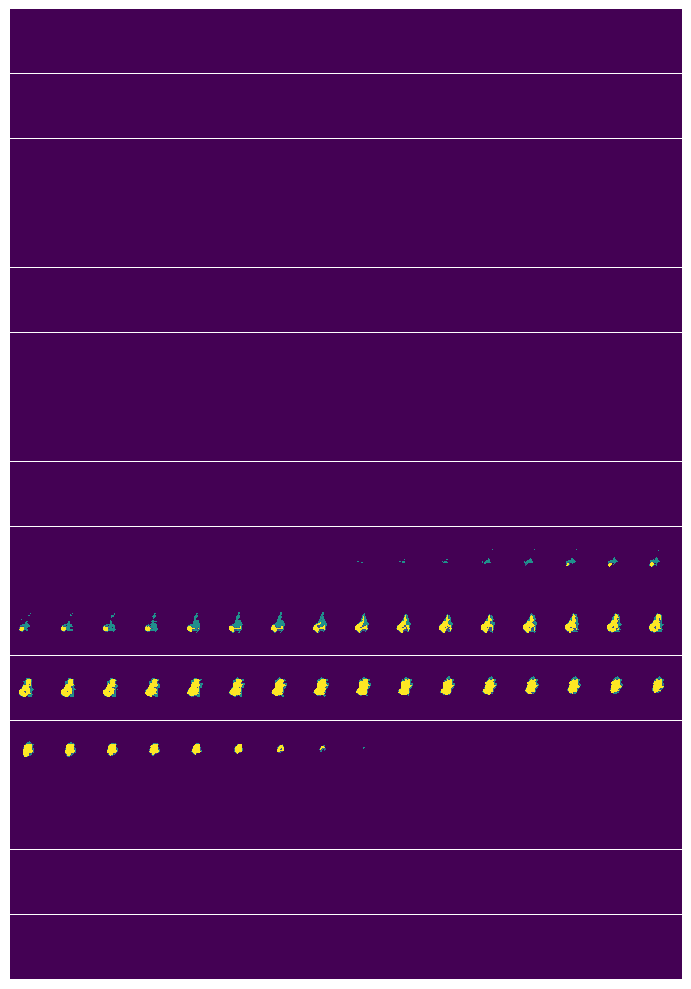

In [ ]:
monai.visualize.utils.matshow3d(img)

In [ ]:

file_path='/content/drive/MyDrive/brats/Task01_BrainTumour/imagesTr/BRATS_035.nii.gz'
mask_file_path='/content/drive/MyDrive/monai_results/BRATS_035/BRATS_035_seg.nii.gz'

In [ ]:
import sys

!{sys.executable} -m pip install -q imageio "itkwidgets[all]>=1.0a23"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 77.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.3/247.3 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.5 MB/s eta 0:00:00

### Using ITK for 3d view of the nifty files

In [ ]:
!pip install itk

In [ ]:

from itkwidgets import view
import itk
import imageio
from monai.transforms.io.array import LoadImage

In [ ]:
img = LoadImage(image_only=True, reader=NibabelReader(), channel_dim=None, affine_lps_to_ras=False)(file_path)


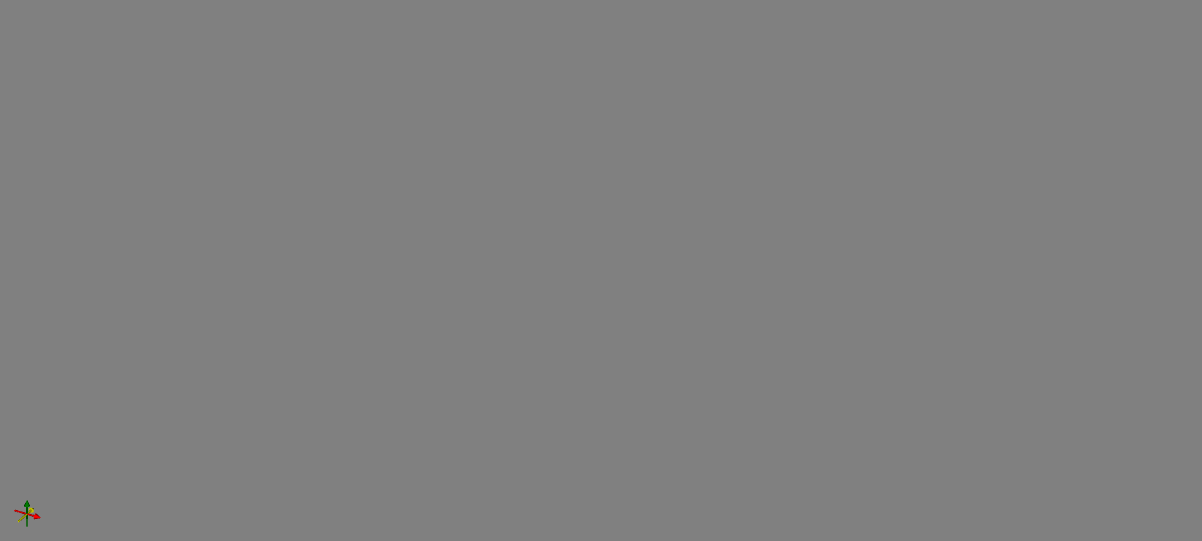
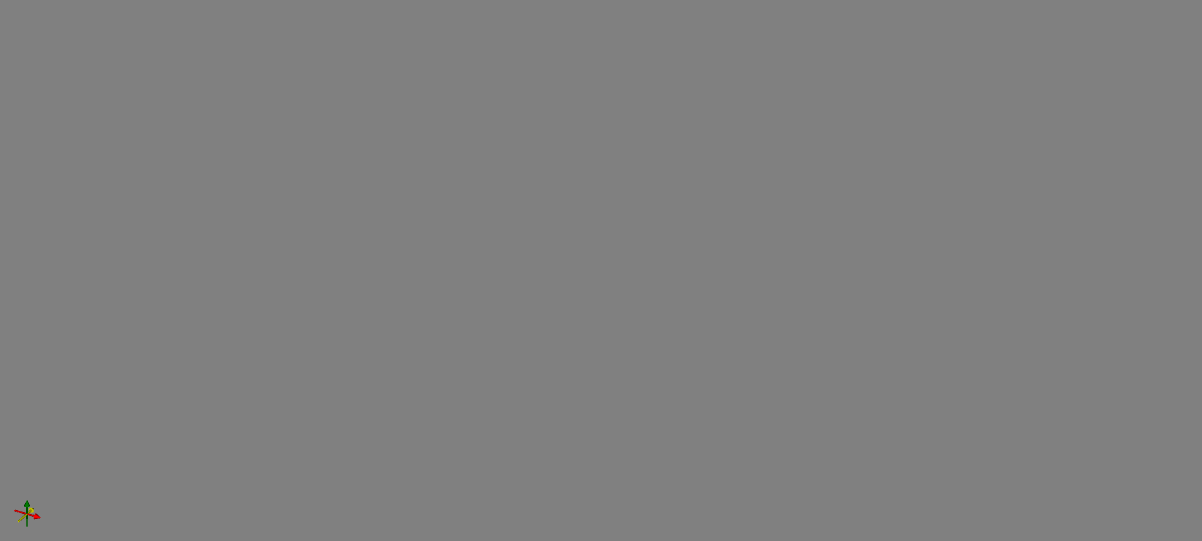

In [ ]:
view(img)

In [ ]:
mask = LoadImage(image_only=True, reader=NibabelReader(), channel_dim=None, affine_lps_to_ras=False)(mask_file_path)


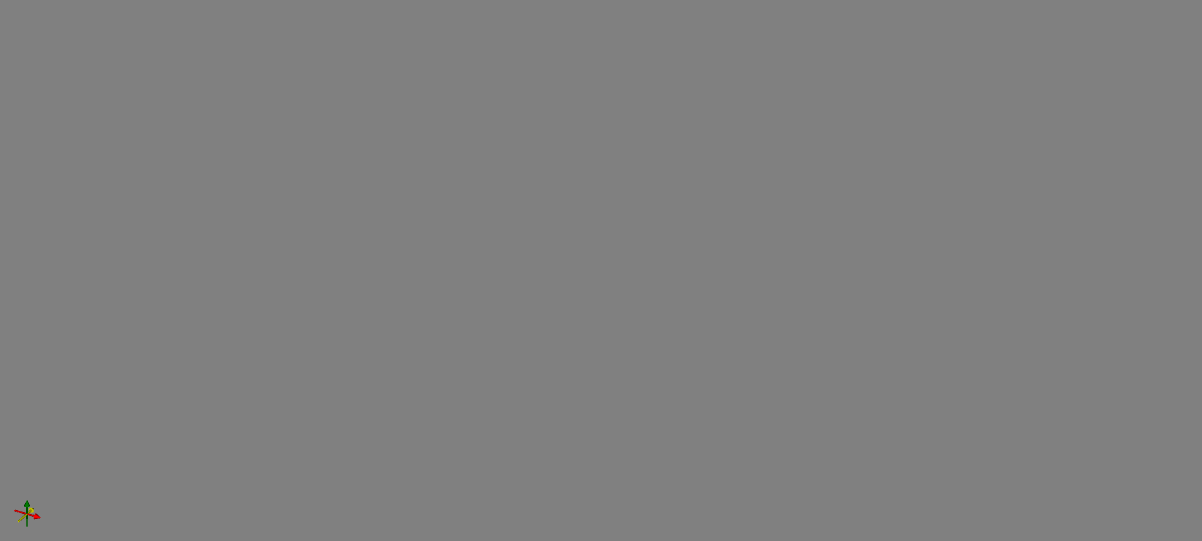
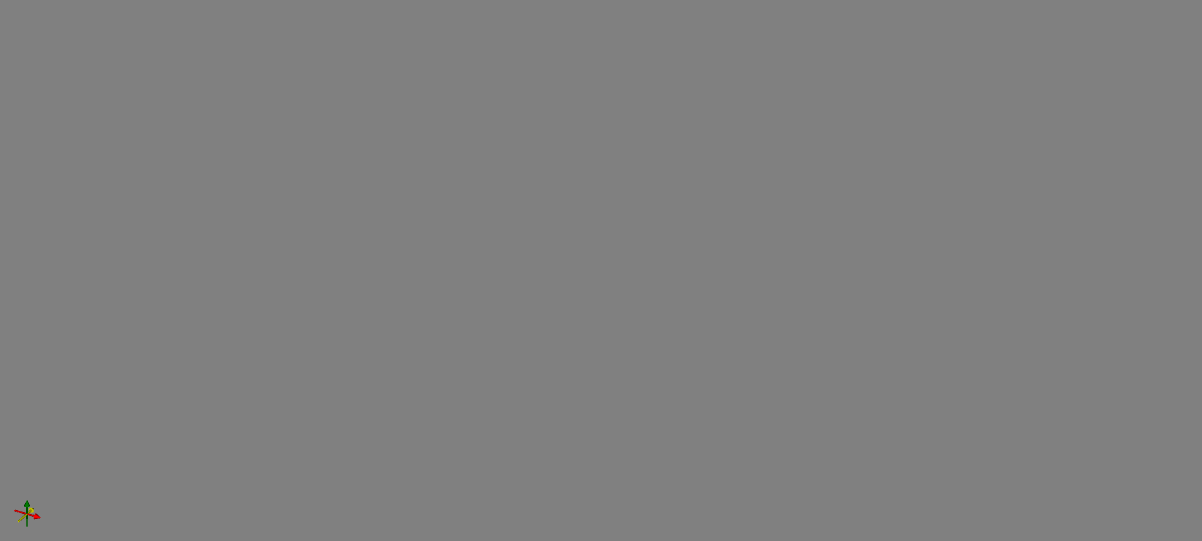

In [ ]:
view(mask)

In [ ]:
import monai.transforms as transforms
import nibabel as nib
import torch

# Load the original NIfTI image
original_image = nib.load(file_path)  # Replace with your file path

# Convert the loaded image data to a PyTorch tensor
image_data = torch.tensor(original_image.get_fdata())

# Create an instance of the ConvertToMultiChannelBasedOnBratsClassesd transform
brats_transform = transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="image")

# Apply the transform to the image
transformed_data = brats_transform({"image": image_data})

# The transformed_data now contains the multi-channel representation of the image


In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Load the original NIfTI image
original_image = nib.load(file_path)  # Replace with your file path

# Load the predicted label (replace with your predicted label file)
predicted_label = nib.load(mask_file_path)  # Replace with your file path

# Get the image data from the original image
image_data = original_image.get_fdata()

# Get the label data from the predicted label
label_data = predicted_label.get_fdata()

# Overlay the label data on the original image by setting label pixels to a specific value (e.g., 255)
overlayed_image = image_data.copy()
overlayed_image[label_data > 0] = 255




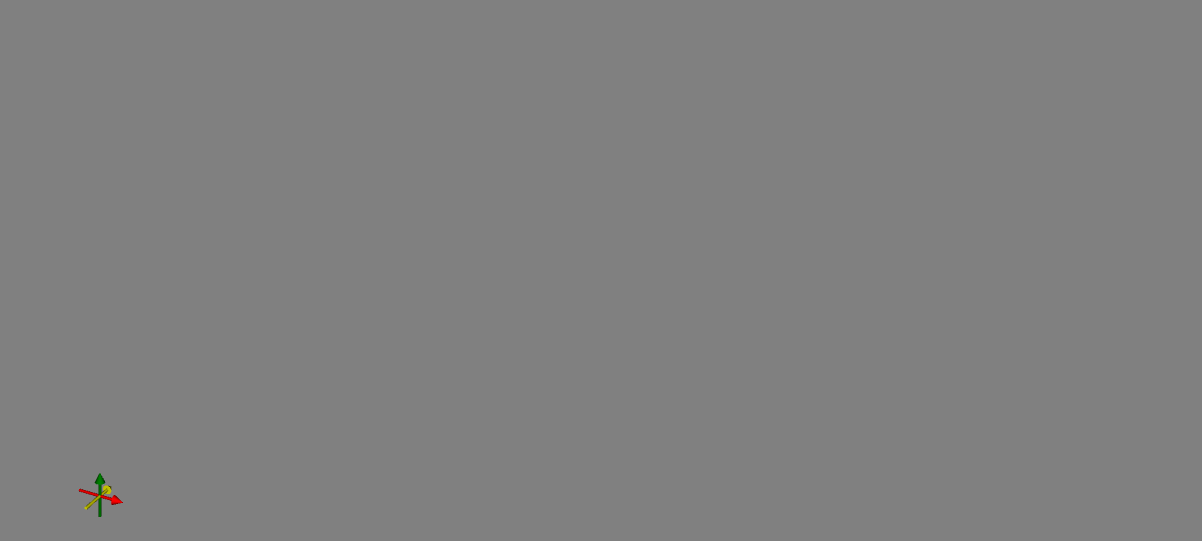
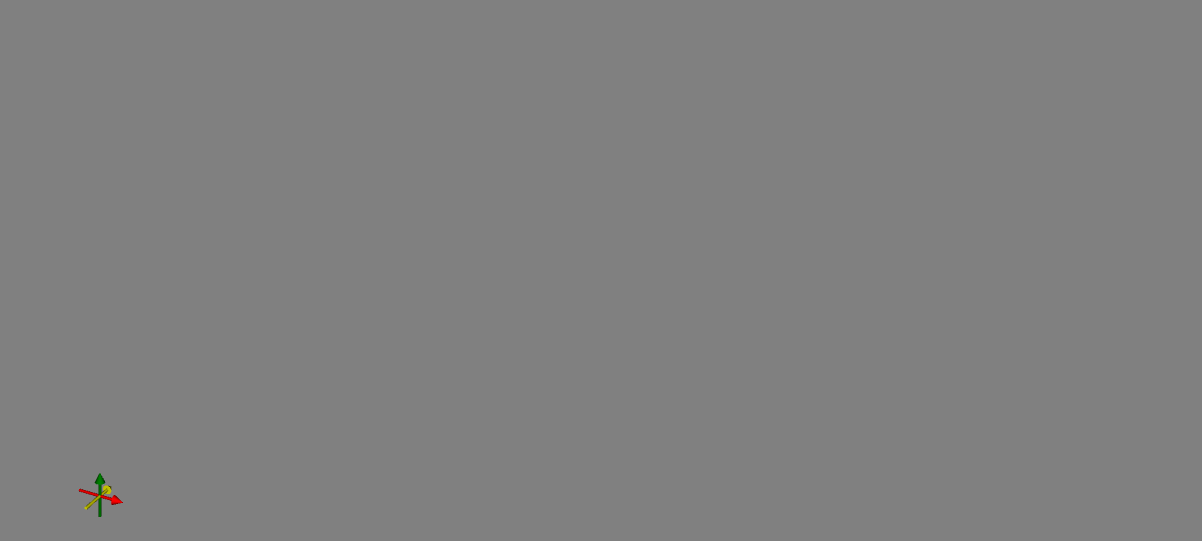

In [ ]:
view(overlayed_image)